Multiplexed smFISH on mouse cortex

# Imports

In [42]:
import loompy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pickle
from collections import Counter
import scipy
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams.update({'figure.max_open_warning': 150})

%matplotlib notebook

# Import Data

## smFISH

In [6]:
file_name = '/home/lars/storage/Documents/Cortex_FISH/CountsV1-1.loom'
ds = loompy.connect(file_name)

#Cell size in dictionary. convert pixels to square um (pixel size = 0.065um)
cell_size = dict(zip(ds.CellID, (np.sqrt(ds.CellArea)*0.065)**2))

In [40]:
def loompy2data(filename, cutoff_low, cutoff_high, molecules_low):
    """
    Loom file to Panda's dataframe. Perform size and count selection on cells
    Input:
    `filename`(str): Name and path tot the Loom file
    `cutoff_low`(flt): Minimal cell size (in number of pixels, square um = (np.sqrt(pixels)*0.065)**2
    `cutoff_high`(flt): Max cell size (in number of pixels, square um = (np.sqrt(pixels)*0.065)**2
    `molecules_low`(int): Minimal number of molecules
    Returns:
    Panda's dataframe with cells that passed the criteria. df has cell label as column name. 
    Some gene names are corrected
    Metadata is discarded. 
    
    """
    #Read loom file and import to Pandas df
    ds = loompy.connect(filename)
    df=pd.DataFrame(data=ds[:,:], columns=ds.col_attrs['CellID'], index=ds.row_attrs['genes']).astype(int)
    
    #Filter cell size
    for i, j in enumerate(ds.col_attrs['CellID']):
        if ds.col_attrs['CellArea'][i] < cutoff_low or ds.col_attrs['CellArea'][i] > cutoff_high:
            del df[j]
    
    #Filter total molecule count
    for i, j in enumerate(ds.col_attrs['CellID']):
        try: #not all 'CellID' are still present
            if df[j].sum() < molecules_low:
                del df[j]
        except Exception:
            pass
        
    #Filter bad hybridiztion4 (out of focus imaging) and repeat Tbr1
    bad_data = ['Hybridization4_Cnr1', 'Hybridization4_Plp1', 'Hybridization4_Vtn', 'Hybridization11_Tbr1']
    for i in bad_data:
        df.drop(i, inplace=True)
     
    #Change incorrect names Tmem6-->Tmem2 and Kcnip-->Kcnip2
    df= df.rename({'Hybridization11_Tmem6': 'Hybridization11_Tmem2', 'Hybridization12_Kcnip': 'Hybridization12_Kcnip2'})
    
    print('Selected cells with  {}>size<{} and a minimum molecule count of {} molecules'.format(cutoff_low, cutoff_high, molecules_low))
    print('Change incorrect names Tmem6-->Tmem2 and Kcnip-->Kcnip2')
    return df

    
df_fish = loompy2data(file_name, 2000, 60000, 20)

gene_sort_fish = ['Hybridization2_Gad2', 'Hybridization12_Slc32a1', 'Hybridization10_Crhbp', 'Hybridization12_Kcnip2', 'Hybridization13_Cnr1', 'Hybridization6_Vip', 'Hybridization5_Cpne5', 'Hybridization8_Pthlh',  'Hybridization10_Crh', 
'Hybridization1_Tbr1', 'Hybridization9_Lamp5', 'Hybridization7_Rorb', 'Hybridization11_Syt6',
'Hybridization1_Aldoc', 'Hybridization2_Gfap', 'Hybridization8_Serpinf1', 'Hybridization3_Mfge8',
 'Hybridization7_Sox10', 'Hybridization13_Plp1', 'Hybridization8_Pdgfra', 'Hybridization6_Bmp4','Hybridization6_Itpr2','Hybridization11_Tmem2', 'Hybridization7_Ctps','Hybridization5_Klk6','Hybridization9_Anln',
 'Hybridization3_Mrc1','Hybridization3_Hexb', 
 'Hybridization13_Ttr',
 'Hybridization1_Foxj1',
 'Hybridization12_Vtn',
 'Hybridization2_Flt1',
 'Hybridization10_Apln',
 'Hybridization5_Acta2',
 'Hybridization9_Lum']

gene_sort = ['Gad2', 'Slc32a1', 'Crhbp', 'Kcnip2', 'Cnr1', 'Vip', 'Cpne5', 'Pthlh', 'Crh',             
             'Tbr1', 'Lamp5', 'Rorb', 'Syt6', 
             'Aldoc', 'Gfap', 'Serpinf1', 'Mfge8', 
             'Sox10', 'Plp1', 'Pdgfra', 'Bmp4', 'Itpr2', 'Tmem2',  'Ctps',  'Klk6', 'Anln',   
             'Mrc1', 'Hexb', 
             'Ttr', 
             'Foxj1', 
             'Vtn', 'Flt1', 'Apln', 'Acta2',  'Lum'] 

df_fish = df_fish.loc[gene_sort_fish]

Selected cells with  2000>size<60000 and a minimum molecule count of 20 molecules
Change incorrect names Tmem6-->Tmem2 and Kcnip-->Kcnip2


In [8]:
# normalize data by total number of molecules per cell and per gene.
df_fish_totmol = df_fish.divide(df_fish.sum(axis=1), axis=0) * df_fish.shape[0] #Corrected for total molecules per gene
df_fish_totmol = df_fish_totmol.divide(df_fish_totmol.sum(axis=0), axis=1) * df_fish.shape[1] #Corrected for the total per cell
df_fish_totmol.head(5)

1124        2325        2400         241  \
Hybridization2_Gad2      59.097363  134.832042   68.620327   70.789709   
Hybridization12_Slc32a1  45.000240   89.835481  121.920377   75.464881   
Hybridization10_Crhbp    88.751819    0.000000  120.228861    0.000000   
Hybridization12_Kcnip2    6.062614  605.149902  821.280234  142.337062   
Hybridization13_Cnr1     20.810705   83.090210  112.766021  488.590357   

                                6248        5992         275        2573  \
Hybridization2_Gad2       634.761084   87.098014  153.993551   18.144337   
Hybridization12_Slc32a1   572.577649    0.000000   58.629915    0.000000   
Hybridization10_Crhbp       0.000000    0.000000    0.000000    0.000000   
Hybridization12_Kcnip2     42.076347  187.637373  315.954340  182.414340   
Hybridization13_Cnr1     1348.036639  644.089532  325.366231  313.080398   

                                330        1149     ...            5162  \
Hybridization2_Gad2       31.940752  105.881257     ...       51.500036   
Hybridization12_Slc32a1   85.125546    0.000000     ...        0.000000   
Hybridization10_Crhbp      0.000000  139.134971     ...        0.000000   
Hybridization12_Kcnip2    80.279197    0.000000     ...      462.282422   
Hybridization13_Cnr1     196.834798   65.249296     ...      190.421298   

                                532        3607       3251       7173  \
Hybridization2_Gad2      133.533634  103.633295  35.458330  31.192269   
Hybridization12_Slc32a1   59.313587   30.688211   0.000000   0.000000   
Hybridization10_Crhbp      0.000000    0.000000   0.000000   0.000000   
Hybridization12_Kcnip2   367.584416  529.208251   0.000000  22.399422   
Hybridization13_Cnr1     164.580132  709.599886  43.702373  76.888910   

                               2757       1228        1234        7797  \
Hybridization2_Gad2       32.304901  58.069634  156.791371  102.966098   
Hybridization12_Slc32a1  172.192083   0.000000    0.000000    0.000000   
Hybridization10_Crhbp      0.000000   0.000000    0.000000    0.000000   
Hybridization12_Kcnip2    23.198411   0.000000    0.000000   73.940791   
Hybridization13_Cnr1     119.447318   0.000000    0.000000    0.000000   

                               4653  
Hybridization2_Gad2      216.161380  
Hybridization12_Slc32a1    0.000000  
Hybridization10_Crhbp      0.000000  
Hybridization12_Kcnip2   310.454484  
Hybridization13_Cnr1     290.638673  

[5 rows x 6036 columns]

In [116]:
df_fish_log = df_fish / df_fish.sum(axis=0)
df_fish_log = np.log2(df_fish_log + 1)

"""X_norm = X.sum(0).mean() * (X/X.sum(0))
    #Log transform
X_log = np.log2(X_norm+1)

    #Build dataframes of normalized and log transformed data
df_fish_sqrt = pd.DataFrame(data=X_sqrt, columns=df_fish.columns, index=df_fish.index)
df_fish_norm = pd.DataFrame(data=X_norm, columns=df_fish.columns, index=df_fish.index)
df_fish_log = pd.DataFrame(data=X_log, columns=df_fish.columns, index=df_fish.index)"""

'X_norm = X.sum(0).mean() * (X/X.sum(0))\n    #Log transform\nX_log = np.log2(X_norm+1)\n\n    #Build dataframes of normalized and log transformed data\ndf_fish_sqrt = pd.DataFrame(data=X_sqrt, columns=df_fish.columns, index=df_fish.index)\ndf_fish_norm = pd.DataFrame(data=X_norm, columns=df_fish.columns, index=df_fish.index)\ndf_fish_log = pd.DataFrame(data=X_log, columns=df_fish.columns, index=df_fish.index)'

In [115]:
df_fish_log

1124      2325      2400       241      6248  \
Hybridization2_Gad2      0.023490  0.032787  0.015075  0.019231  0.242537   
Hybridization12_Slc32a1  0.006711  0.008197  0.010050  0.007692  0.082090   
Hybridization10_Crhbp    0.006711  0.000000  0.005025  0.000000  0.000000   
Hybridization12_Kcnip2   0.003356  0.204918  0.251256  0.053846  0.022388   
Hybridization13_Cnr1     0.003356  0.008197  0.010050  0.053846  0.208955   
Hybridization6_Vip       0.043624  0.008197  0.010050  0.015385  0.111940   
Hybridization5_Cpne5     0.000000  0.032787  0.005025  0.003846  0.003731   
Hybridization8_Pthlh     0.006711  0.000000  0.000000  0.000000  0.029851   
Hybridization10_Crh      0.006711  0.000000  0.010050  0.000000  0.011194   
Hybridization1_Tbr1      0.043624  0.090164  0.140704  0.046154  0.026119   
Hybridization9_Lamp5     0.020134  0.311475  0.256281  0.484615  0.000000   
Hybridization7_Rorb      0.013423  0.000000  0.000000  0.003846  0.000000   
Hybridization11_Syt6     0.003356  0.131148  0.100503  0.000000  0.000000   
Hybridization1_Aldoc     0.127517  0.000000  0.045226  0.019231  0.141791   
Hybridization2_Gfap      0.191275  0.000000  0.005025  0.000000  0.003731   
Hybridization8_Serpinf1  0.043624  0.008197  0.010050  0.023077  0.007463   
Hybridization3_Mfge8     0.020134  0.000000  0.005025  0.007692  0.000000   
Hybridization7_Sox10     0.174497  0.000000  0.005025  0.003846  0.011194   
Hybridization13_Plp1     0.033557  0.040984  0.015075  0.000000  0.026119   
Hybridization8_Pdgfra    0.003356  0.008197  0.010050  0.000000  0.003731   
Hybridization6_Bmp4      0.003356  0.000000  0.000000  0.000000  0.000000   
Hybridization6_Itpr2     0.013423  0.000000  0.000000  0.003846  0.000000   
Hybridization11_Tmem2    0.006711  0.000000  0.000000  0.011538  0.003731   
Hybridization7_Ctps      0.020134  0.024590  0.045226  0.057692  0.011194   
Hybridization5_Klk6      0.000000  0.000000  0.000000  0.000000  0.000000   
Hybridization9_Anln      0.063758  0.008197  0.005025  0.003846  0.007463   
Hybridization3_Mrc1      0.046980  0.016393  0.010050  0.011538  0.007463   
Hybridization3_Hexb      0.033557  0.000000  0.015075  0.023077  0.003731   
Hybridization13_Ttr      0.006711  0.000000  0.000000  0.003846  0.003731   
Hybridization1_Foxj1     0.000000  0.000000  0.000000  0.003846  0.018657   
Hybridization12_Vtn      0.006711  0.016393  0.000000  0.003846  0.007463   
Hybridization2_Flt1      0.000000  0.000000  0.000000  0.000000  0.000000   
Hybridization10_Apln     0.010067  0.040984  0.010050  0.119231  0.000000   
Hybridization5_Acta2     0.010067  0.008197  0.005025  0.003846  0.003731   
Hybridization9_Lum       0.003356  0.000000  0.000000  0.011538  0.000000   

                             5992      275      2573       330      1149  \
Hybridization2_Gad2      0.026316  0.04375  0.005618  0.012121  0.051282   
Hybridization12_Slc32a1  0.000000  0.00625  0.000000  0.012121  0.000000   
Hybridization10_Crhbp    0.000000  0.00000  0.000000  0.000000  0.012821   
Hybridization12_Kcnip2   0.078947  0.12500  0.078652  0.042424  0.000000   
Hybridization13_Cnr1     0.078947  0.03750  0.039326  0.030303  0.012821   
Hybridization6_Vip       0.026316  0.01875  0.011236  0.006061  0.017094   
Hybridization5_Cpne5     0.000000  0.01250  0.050562  0.012121  0.000000   
Hybridization8_Pthlh     0.000000  0.00625  0.005618  0.000000  0.000000   
Hybridization10_Crh      0.000000  0.03750  0.005618  0.000000  0.008547   
Hybridization1_Tbr1      0.157895  0.08750  0.134831  0.030303  0.012821   
Hybridization9_Lamp5     0.026316  0.32500  0.247191  0.309091  0.000000   
Hybridization7_Rorb      0.105263  0.00000  0.000000  0.012121  0.012821   
Hybridization11_Syt6     0.000000  0.01875  0.117978  0.006061  0.008547   
Hybridization1_Aldoc     0.052632  0.02500  0.016854  0.042424  0.042735   
Hybridization2_Gfap      0.000000  0.01875  0.016854  0.000000  0.136752   
Hybridization8_Serpinf1  0.105263  0.012

In [9]:
#Open object properties
obj_prop = pickle.load(open("ObjProp_dict.pkl", 'rb'))

#Load cell ID and XY coordinates into a list
coord_list = []
for i in obj_prop:
    coord_list.append([i, obj_prop[i]['obj_centroid'][0], obj_prop[i]['obj_centroid'][1]])
    
#Place cell ID and X and Y coordinates into dataframe
coord_df = pd.DataFrame(coord_list, columns=['Cell_ID', 'X', 'Y']).set_index('Cell_ID').T
coord_df = coord_df.loc[:,df_fish.columns]

## Single Cell

# Comparison smFISH & Single Cell

## Counts

In [ ]:
# also compare the genes to see where the difference is coming from. 

## tSNE comparison

# tSNE

In [10]:
def scatter_tSNE(tSNE_data):
    
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(tSNE_data[:,0], tSNE_data[:,1], lw=0, s=40, alpha = 0.1, c = 'blue')
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('on')
    ax.axis('tight')
    
    return f, ax, sc

<IPython.core.display.Javascript object>


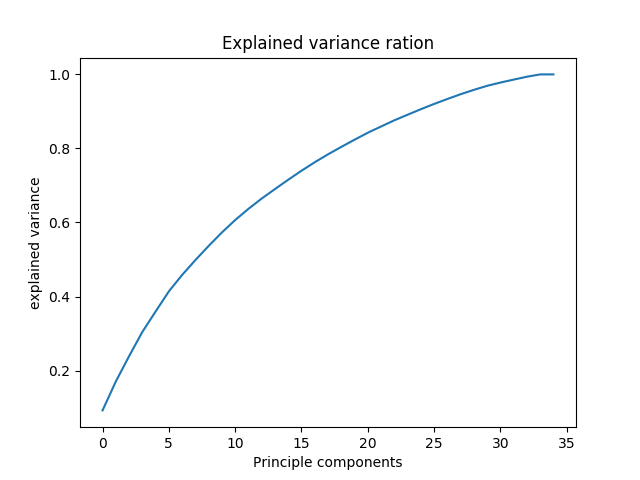

In [11]:
pca = PCA()
pc = pca.fit_transform(df_fish_totmol.T)

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Explained variance ration')
plt.xlabel('Principle components')
plt.ylabel('explained variance')

<IPython.core.display.Javascript object>


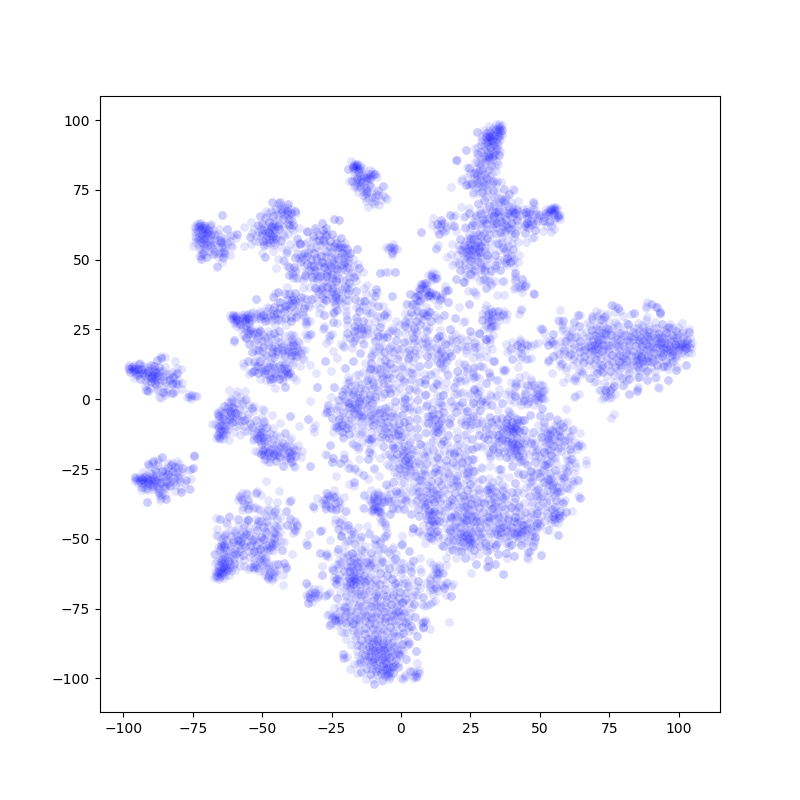

In [14]:
model = TSNE(n_iter=5000, perplexity=50, early_exaggeration=15)
#Transpose the data to work on the cells
tSNE_points = model.fit_transform(pc[:,:33])
scatter_tSNE(tSNE_points)
pickle.dump(tSNE_points, open( "tSNE_points_df_tot_mol_p50_ea15.p", "wb" ))

<IPython.core.display.Javascript object>


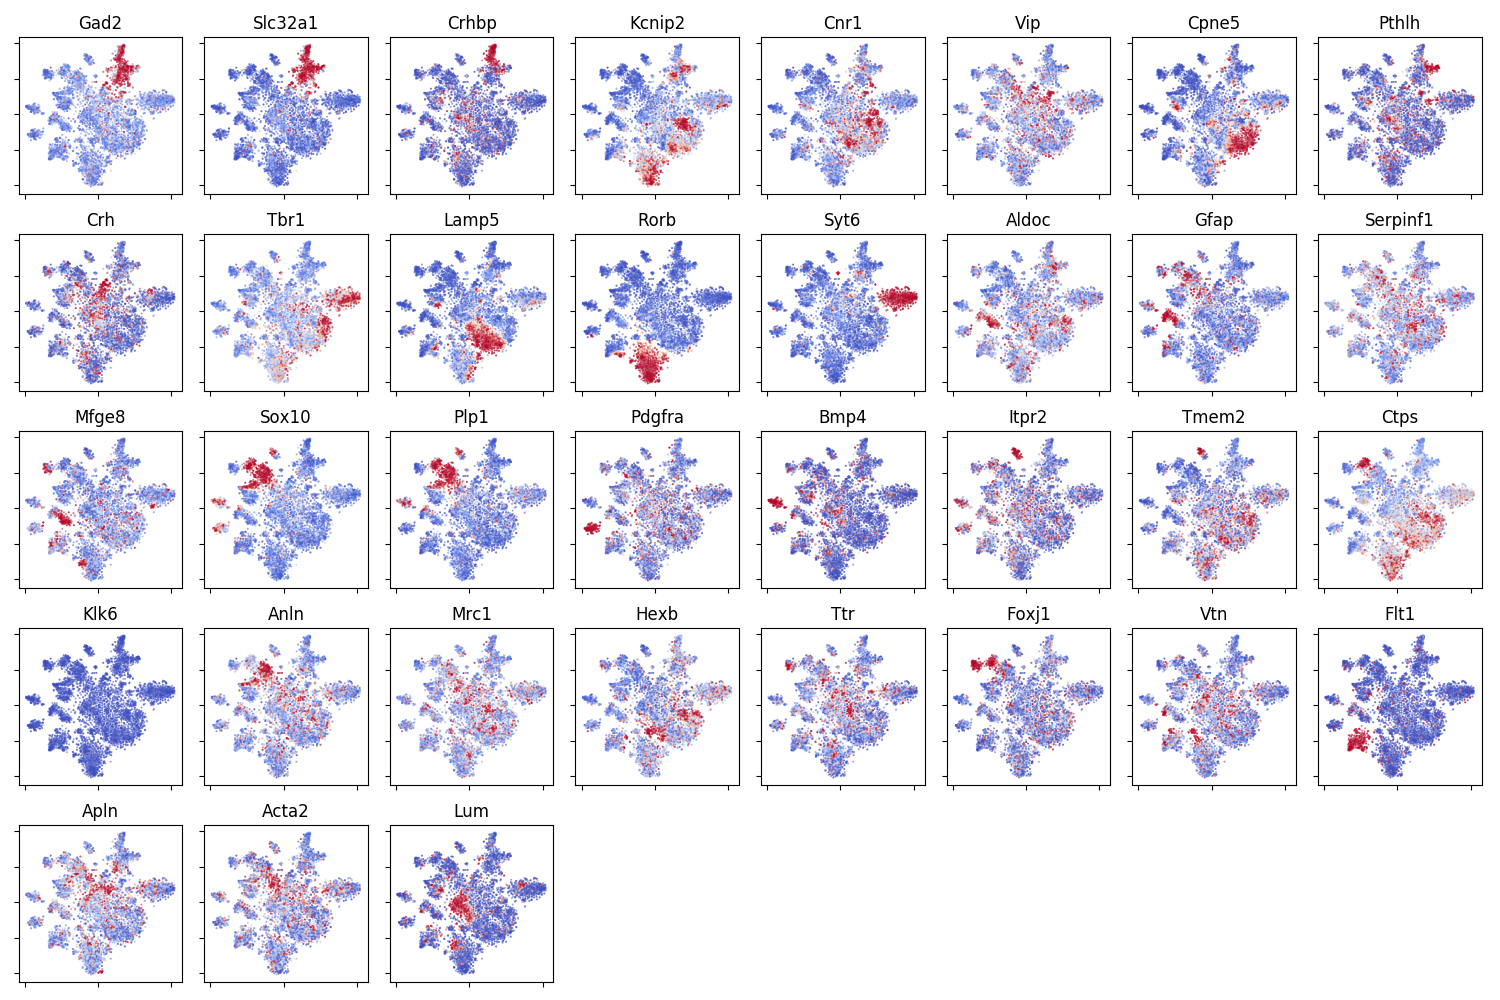

/home/lars/programs/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/lars/programs/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


In [19]:
#Expression plot on tSNE points
plt.figure(figsize=(15,10))
gs = plt.GridSpec(5,8)

for i, gene in enumerate(gene_sort_fish):
    plt.subplot(gs[i])
    filt = df_fish.index == gene
    levels = df_fish_totmol.loc[filt,:].values.flat[:]
    levels = np.clip(levels, np.percentile(levels, 10), np.percentile(levels,90))
    plt.scatter(tSNE_points[:,0], tSNE_points[:,1],color=plt.cm.coolwarm(levels/max(levels)), lw=0, alpha=.5,s=2)
    for label in plt.gca().axes.get_xticklabels():
        label.set_visible(False)
    for label in plt.gca().axes.get_yticklabels():
        label.set_visible(False)
    plt.title(gene.split('_')[1])
plt.tight_layout()

# Clustering

In [56]:
def mean_expression(df, labels):
    """
    Make dataframe with mean expression
    
    """
    #Make df with count averages per cluster
    df_count_average = pd.DataFrame(index=df.index, columns=np.sort(np.unique(labels))) #np.unique(labels_a))
    for l in np.unique(labels):
        filt = labels == l
        mean = np.array(df.loc[:,filt].T.mean())
        #std = np.array(np.std(df_sort.loc[:,filt], axis=1))
        if np.isnan(np.sum(mean)) == False: #In case some clusters do not have cells
            df_count_average[l] = mean
    return df_count_average

def heat_map(df, labels, sort=None, save=False, name=''):
    """
    Plot heat_map of a sorted dataframe
    
    """
    #Find the name of the input df, for logging
    df_input_name =[x for x in globals() if globals()[x] is df][0]
    print('DF used for plot: {}'.format(df_input_name))
    
    if sort == None:
        optimal_order = np.unique(labels)    
    else:
        optimal_order = sort
    print('Order of clusters: {}'.format(optimal_order))
    
    #Sort the cells according to the optimal cluster order
    optimal_sort_cells = []
    for i in optimal_order:
        optimal_sort_cells.extend(label_cells[i])
    
    #Create a list of optimal sorted cell labels
    optimal_sort_labels = []
    for i in optimal_sort_cells:
        optimal_sort_labels.append(cell_labels[i])
    
    fig, axHM = plt.subplots(figsize=(14,6))
    #z = df.loc[:,optimal_sort_cells].values
    #z = z/np.percentile(z, 99.5, 1)[:,None]
    
    df_full = df # _fish_log
    z = df_full.values
    z = z/np.percentile(z, 99, 1)[:,None]
    z = pd.DataFrame(z, index=df_full.index, columns=df_full.columns)
    z = z.loc[:,optimal_sort_cells].values
    print(z.shape)
    
    im = axHM.pcolor(z, cmap='viridis', vmax=1)

    plt.yticks(np.arange(0.5, len(df.index), 1), gene_sort, fontsize=8)
    plt.gca().invert_yaxis()
    plt.xlim(xmax=len(labels))
    print(len(labels))
    plt.title(df_input_name)

    divider = make_axes_locatable(axHM)
    axLabel = divider.append_axes("top", .3, pad=0, sharex=axHM)

    optimal_sort_labels = np.array(optimal_sort_labels)
    axLabel.pcolor(optimal_sort_labels[None,:]/max(optimal_sort_labels), cmap='jet')
        #Colors, see below:
    #axLabel.pcolor(label_colors_rgb) #label_colors_hex
    
    
    
    axLabel.set_xlim(xmax=len(labels))
    axLabel.axis('off')
    
    cax = fig.add_axes([.91, 0.13, 0.01, 0.22])
    colorbar = fig.colorbar(im, cax=cax, ticks=[0,1])
    colorbar.set_ticklabels(['0', 'max'])
    
    if save == True:
        plt.savefig('{}.png'.format(name), dpi=300)
    
    
def gen_labels(df, model):
    """
    Generate cell labels from model.
    Input:
    `df`: Panda's dataframe that has been used for the clustering. (used to get
    the names of colums and rows)
    `model`(obj): Clustering object
    Returns (in this order):
    `cell_labels` = Dictionary coupling cellID with cluster label
    `label_cells` = Dictionary coupling cluster labels with cellID
    `cellID` = List of cellID in same order as labels
    `labels` = List of cluster labels in same order as cells
    `labels_a` = Same as "labels" but in numpy array
    
    """
    if str(type(model)).startswith("<class 'sklearn.cluster"):
        cell_labels = dict(zip(df.columns, model.labels_))
        label_cells = {}
        for l in np.unique(model.labels_):
            label_cells[l] = []
        for i, label in enumerate(model.labels_):
            label_cells[label].append(df.columns[i])
        cellID = list(df.columns)
        labels = list(model.labels_)
        labels_a = model.labels_
    elif type(model) == np.ndarray:
        cell_labels = dict(zip(df.columns, model))
        label_cells = {}
        for l in np.unique(model):
            label_cells[l] = []
        for i, label in enumerate(model):
            label_cells[label].append(df.columns[i])
        cellID = list(df.columns)
        labels = list(model)
        labels_a = model
    else:
        print('Error wrong input type')
    
    return cell_labels, label_cells, cellID, labels, labels_a


In [148]:

    


def iterative_clustering(df, expression_threshold, alpha, min_clust_size, dataset_fraction = 0.1, allow_level_difference=False, max_cycles = 50):
    
    def cluster_evaluation(df1, df2, expression_threshold, alpha, dataset_fraction, allow_level_difference=False):
        """
        Check if the clusters pass the criteria

        """
        evaluation = [0,0]

        #Investigate if there are genes enriched in a cluster
        enriched_df1 = df1[df1.mean(axis=1) > expression_threshold].index.tolist()
        enriched_df2 = df2[df2.mean(axis=1) > expression_threshold].index.tolist()

        if df1.shape[1] > (dataset_fraction * df.shape[1]) or df2.shape[1] > (dataset_fraction * df.shape[1]):
            evaluation[0] = 3

        elif enriched_df1 == [] and enriched_df2 == []: #No enriched genes in both groups
            evaluation[0] = 0
        elif enriched_df1 == enriched_df2: #Same enriched genes for both groups, level difference
            if allow_level_difference == True:
                evaluation[0] = 1
            else:
                evaluation[0] = 0
        elif enriched_df1 != enriched_df2: #At least one gene differential enriched
            evaluation[0] = 2



        #Test if there is a significant difference in the enriched genes between the groups
        diff_expressed = {'df1':[],
                          'df2':[],
                          'both':[]}
        for gene in [i for i in enriched_df1 if i in enriched_df2]:
            test_p = scipy.stats.mannwhitneyu(df1.loc[gene], df2.loc[gene], alternative='two-sided')[1]
            if test_p < alpha:
                diff_expressed['both'].append([gene, test_p])
                evaluation[1] = 1
        for gene in [i for i in enriched_df1 if i not in enriched_df2]:
            test_p = scipy.stats.mannwhitneyu(df1.loc[gene], df2.loc[gene], alternative='two-sided')[1]
            if test_p < alpha:
                diff_expressed['df1'].append([gene, test_p])
                evaluation[1] = 2
        for gene in [i for i in enriched_df2 if i not in enriched_df1]:
            test_p = scipy.stats.mannwhitneyu(df1.loc[gene], df2.loc[gene], alternative='two-sided')[1]
            if test_p < alpha:
                diff_expressed['df2'].append([gene, test_p])
                evaluation[1] = 2
        return evaluation

    def re_cluster(dfs = []):
        """
        Evaluate a list of clusters (dataframes) by splitting them again and 
        evaluating the daughter clusters.
        Input:
        `dfs`(list): List of Pandas dataframes containing one cluster.

        """
        re_evaluation = []
        for d in dfs:
            split = AgglomerativeClustering(n_clusters=2).fit(d.T)
            split_labels = split.labels_ 
            df_daughter_1 = d.loc[:,split_labels == np.unique(split_labels)[0]]
            df_daughter_2 = d.loc[:,split_labels == np.unique(split_labels)[1]]
            re_evaluation.append(cluster_evaluation(df_daughter_1, df_daughter_2, expression_threshold, 
                                                    alpha, dataset_fraction,
                                                    allow_level_difference=allow_level_difference))
        return(re_evaluation)  
    
    finished_clusters = []
    label_ofset = 0

    #Make matrix for labels. First row all zeros
    label_matrix = pd.DataFrame(data= np.zeros((1, df.shape[1])), index = ['Level_0'], columns=df.columns, dtype='Int64')

    for cycle, x in enumerate(range(max_cycles)):

        previous_level = 'Level_{}'.format(cycle)
        current_level = 'Level_{}'.format(cycle + 1)

        if list(set(label_matrix.loc[previous_level]) - set(finished_clusters)) == []:
            print('DONE DONE DONE')
            break

        #Add row and copy labels
        label_matrix.loc[current_level] = label_matrix.loc[previous_level]

        #Loop through all labels that are not in finished_clusters
        for old_label in [i for i in np.unique(label_matrix.loc[current_level]) if i not in finished_clusters]:
            label_ofset += 2
            print(current_level, 'label: ', old_label)

            #Create dataframe to split
            filt = label_matrix.loc[current_level] == old_label
            df_to_split = df.loc[:,filt]

            #Cluster dataframe into two clusters
            split = AgglomerativeClustering(n_clusters=2).fit(df_to_split.T)
            split_labels = split.labels_ + label_ofset #Labels are 0 and 1, shift them with the clustering step
            unique_split_labels = np.unique(split_labels)
            print('unique_split_labels:  {}'.format(repr(unique_split_labels)))

            #Check if all the clusters are larger than the min_clust_size
            if all(i > min_clust_size for i in list(Counter(split_labels).values())):

                #Make df1 & df2
                df1 = df_to_split.loc[:,split_labels == unique_split_labels[0]]
                df2 = df_to_split.loc[:,split_labels == unique_split_labels[1]]

                #Evaluate split
                evaluation = cluster_evaluation(df1, df2, expression_threshold, alpha, dataset_fraction)

                print('LABELS: {} EVALUATION: {}'.format(unique_split_labels, evaluation))
                #List of the labels that are valid clusters (or will be in the next cycle)
                valid_labels = []

                #_____________________________________________________________________
                if evaluation[0] == 3:
                    threshold = dataset_fraction * df.shape[1]
                    if df1.shape[1] > threshold and df2.shape[1] > threshold:
                        valid_labels.extend(unique_split_labels)
                    elif df1.shape[1] > threshold:
                        valid_labels.append(unique_split_labels[0])
                        re_evaluation = re_cluster([df2])
                        if re_evaluation[0][1] == 0:
                            finished_clusters.append(unique_split_labels[1])
                            valid_labels.append(unique_split_labels[1])
                        else: #Difference in daughters, continue clustering
                            valid_labels.append(unique_split_labels[1])
                    elif df2.shape[1] > threshold:
                        valid_labels.append(unique_split_labels[1])
                        re_evaluation = re_cluster([df1])
                        if re_evaluation[0][1] == 0:
                            finished_clusters.append(unique_split_labels[0])
                            valid_labels.append(unique_split_labels[0])
                        else: #Difference in daughters, continue clustering
                            valid_labels.append(unique_split_labels[0])


                #No enriched genes, NO expression difference
                elif evaluation[0] == 0: #and evaluation[1] == 0:
                    re_evaluation = re_cluster([df1, df2])
                    #No valid daughter clusters in the next cycle
                    if re_evaluation[0][1] == 0 and re_evaluation[1][1] == 0:
                        finished_clusters.append(old_label)
                        print('Encountered a cluster without expression: {}{}'.format(current_level, old_label))
                    #Valid daughter clusters in the next cycle
                    else:
                        valid_labels.extend(unique_split_labels)

                #Different genes enriched, expression difference
                elif evaluation[0] == 2 and evaluation[1] == 2:

                    re_evaluation = re_cluster([df1, df2])
                    print('re_evaluation {}'.format(re_evaluation))
                    #First cluster
                    if re_evaluation[0][1] == 0: #no difference in daughter clusters, current cluster finished
                        print('no future 1')
                        finished_clusters.append(unique_split_labels[0])
                        valid_labels.append(unique_split_labels[0])
                    else: #Difference in daughters, continue clustering
                        valid_labels.append(unique_split_labels[0])
                    #Second cluster
                    if re_evaluation[1][1] == 0: #no difference in daughter clusters, current cluster finished
                        print('no future 2')
                        finished_clusters.append(unique_split_labels[1])
                        valid_labels.append(unique_split_labels[1])
                    else: #Difference in daughters, continue clustering
                        valid_labels.append(unique_split_labels[1])    


                #Different genes enriched, NO expression difference
                elif evaluation[0] == 2 and evaluation[1] == 0:
                    print('Encounterd a difference but no significant difference {} {}-->{}'.format(current_level, old_label, unique_split_labels))
                    re_evaluation = re_cluster([df1, df2])
                    if re_evaluation[0][1] == 0 and re_evaluation[1][1] == 0: #No valid daughter clusters
                        finished_clusters.append(old_label)
                        print('    stopped')
                    else:
                        print('    continued\n')
                        valid_labels.extend(unique_split_labels)

                #Same or more enriched, expression level difference
                elif evaluation[0] > 0 and evaluation[1] == 1:
                    print('Encountered a split with similar genes')
                    if allow_level_difference == True:
                        valid_labels.extend(unique_split_labels)
                        finished_clusters.extend(unique_split_labels)
                    else:
                        finished_clusters.append(old_label)


                #Same enriched, NO expression difference
                elif evaluation[0] == 1 and evaluation[1] == 0:
                    finished_clusters.append(old_label) #Not a valid split, current cluster finished  

                else:
                    print('Did not fit the criteria: {} in: {} {}'.format(evaluation, current_level, old_label))

                #_____________________________________________________________________

            else:
                print('toosmall: {}'.format(old_label))
                finished_clusters.append(old_label)

            #Add labels to matrix
            final_split_labels = [old_label if i not in valid_labels else i for i in split_labels]
            for c, i in enumerate(filt):
                if i == True:
                    count_true = Counter(filt[:c])[True] #Count how many Trues already have been passed
                    label_matrix.loc[current_level][c] = final_split_labels[count_true] #Add the new labels to the label matrix
            print('fc ', finished_clusters)
            
    return label_matrix
                

label_matrix = iterative_clustering(df_fish_totmol, 
                     expression_threshold = 550, 
                     alpha = 0.1e-19,
                     min_clust_size = 10, 
                     dataset_fraction = 0.1, 
                     allow_level_difference=False, 
                     max_cycles = 50)

"""df_fish_totmol, 
                     expression_threshold = 550, 
                     alpha = 0.1e-20,
                     min_clust_size = 10, 
                     dataset_fraction = 0.1, 
                     allow_level_difference=False, 
                     max_cycles = 50)"""

Level_1 label:  0
unique_split_labels:  array([2, 3])
LABELS: [2 3] EVALUATION: [3, 2]
fc  []
Level_2 label:  2
unique_split_labels:  array([4, 5])
LABELS: [4 5] EVALUATION: [3, 2]
fc  []
Level_2 label:  3
unique_split_labels:  array([6, 7])
LABELS: [6 7] EVALUATION: [2, 1]
Encountered a split with similar genes
fc  [3]
Level_3 label:  4
unique_split_labels:  array([8, 9])
LABELS: [8 9] EVALUATION: [3, 2]
fc  [3]
Level_3 label:  5
unique_split_labels:  array([10, 11])
LABELS: [10 11] EVALUATION: [0, 1]
fc  [3]
Level_4 label:  8
unique_split_labels:  array([12, 13])
LABELS: [12 13] EVALUATION: [3, 0]
fc  [3]
Level_4 label:  9
unique_split_labels:  array([14, 15])
LABELS: [14 15] EVALUATION: [0, 1]
Encountered a cluster without expression: Level_49
fc  [3, 9]
Level_4 label:  10
unique_split_labels:  array([16, 17])
LABELS: [16 17] EVALUATION: [2, 1]
Encountered a split with similar genes
fc  [3, 9, 10]
Level_4 label:  11
unique_split_labels:  array([18, 19])
LABELS: [18 19] EVALUATION: [

fc  [3, 9, 10, 18, 19, 27, 29, 23, 36, 39, 33, 47, 49, 51, 53, 54, 55, 58, 59, 61, 63, 65, 67, 68, 69, 72, 73, 62, 64, 80, 81, 71, 85, 87, 89, 90, 91, 93]
Level_15 label:  92
unique_split_labels:  array([94, 95])
LABELS: [94 95] EVALUATION: [2, 2]
re_evaluation [[2, 2], [2, 0]]
no future 2
fc  [3, 9, 10, 18, 19, 27, 29, 23, 36, 39, 33, 47, 49, 51, 53, 54, 55, 58, 59, 61, 63, 65, 67, 68, 69, 72, 73, 62, 64, 80, 81, 71, 85, 87, 89, 90, 91, 93, 95]
Level_16 label:  94
unique_split_labels:  array([96, 97])
LABELS: [96 97] EVALUATION: [2, 2]
re_evaluation [[2, 0], [2, 0]]
no future 1
no future 2
fc  [3, 9, 10, 18, 19, 27, 29, 23, 36, 39, 33, 47, 49, 51, 53, 54, 55, 58, 59, 61, 63, 65, 67, 68, 69, 72, 73, 62, 64, 80, 81, 71, 85, 87, 89, 90, 91, 93, 95, 96, 97]
DONE DONE DONE


'df_fish_totmol, \n                     expression_threshold = 550, \n                     alpha = 0.1e-20,\n                     min_clust_size = 10, \n                     dataset_fraction = 0.1, \n                     allow_level_difference=False, \n                     max_cycles = 50)'

In [151]:
print(len(np.unique(label_matrix.iloc[-1])))
label_matrix

41


1124  2325  2400  241  6248  5992  275  2573  330  1149  ...   5162  \
Level_0      0     0     0    0     0     0    0     0    0     0  ...      0   
Level_1      2     3     3    2     2     2    2     3    2     2  ...      2   
Level_2      4     3     3    4     4     5    4     3    4     4  ...      4   
Level_3      8     3     3    8     8    11    8     3    8     8  ...      8   
Level_4     12     3     3   12    12    18   12     3   12    12  ...     12   
Level_5     20     3     3   20    20    18   20     3   20    20  ...     20   
Level_6     24     3     3   24    25    18   24     3   24    24  ...     25   
Level_7     32     3     3   32    35    18   32     3   33    32  ...     35   
Level_8     41     3     3   40    46    18   40     3   33    40  ...     46   
Level_9     55     3     3   52    61    18   52     3   33    52  ...     60   
Level_10    55     3     3   66    61    18   67     3   33    66  ...     72   
Level_11    55     3     3   78    61    18   67     3   33    79  ...     72   
Level_12    55     3     3   84    61    18   67     3   33    87  ...     72   
Level_13    55     3     3   88    61    18   67     3   33    87  ...     72   
Level_14    55     3     3   92    61    18   67     3   33    87  ...     72   
Level_15    55     3     3   94    61    18   67     3   33    87  ...     72   
Level_16    55     3     3   97    61    18   67     3   33    87  ...     72   

          532  3607  3251  7173  2757  1228  1234  7797  4653  
Level_0     0     0     0     0     0     0     0     0     0  
Level_1     2     2     2     2     2     2     2     3     2  
Level_2     4     4     4     4     4     4     4     3     4  
Level_3     9     8     8     8     8     8     8     3     8  
Level_4     9    12    13    12    13    13    13     3    12  
Level_5     9    20    22    20    23    22    22     3    20  
Level_6     9    25    28    24    23    28    28     3    25  
Level_7     9    34    38    33    23    38    38     3    34  
Level_8     9    44    50    33    23    50    50     3    45  
Level_9     9    57    64    33    23    64    65     3    59  
Level_10    9    71    64    33    23    64    65     3    59  
Level_11    9    71    64    33    23    64    65     3    59  
Level_12    9    71    64    33    23    64    65     3    59  
Level_13    9    71    64    33    23    64    65     3    59  
Level_14    9    71    64    33    23    64    65     3    59  
Level_15    9    71    64    33    23    64    65     3    59  
Level_16    9    71    64    33    23    64    65     3    59  

[17 rows x 6036 columns]

41
DF used for plot: df_fish_totmol
Order of clusters: [ 3  9 10 18 19 23 27 29 33 36 39 47 49 51 53 54 55 58 59 61 62 63 64 65 67
 68 69 71 72 73 80 81 85 87 89 90 91 93 95 96 97]


<IPython.core.display.Javascript object>


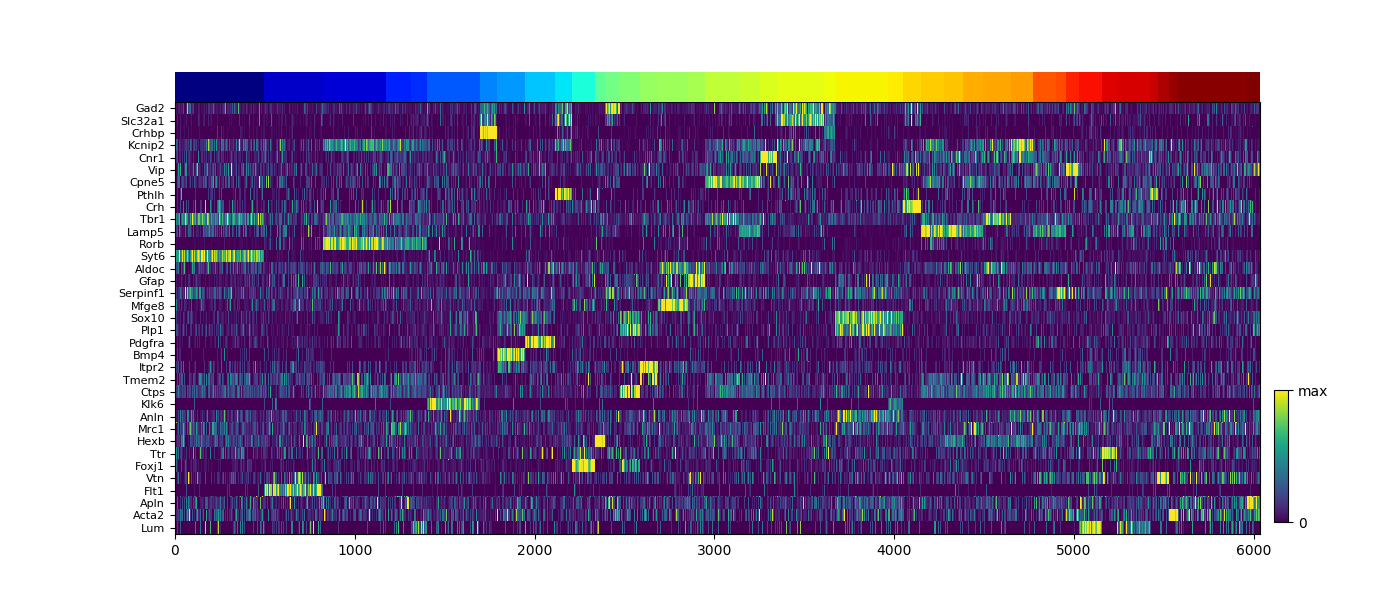

(35, 6036)
6036


In [152]:
last_level = label_matrix.iloc[-1]

cell_labels, label_cells, cellID, labels, labels_a = gen_labels(df_fish_totmol, np.array(last_level))
print(len(np.unique(labels_a)))
heat_map(df_fish_totmol, labels)

<IPython.core.display.Javascript object>


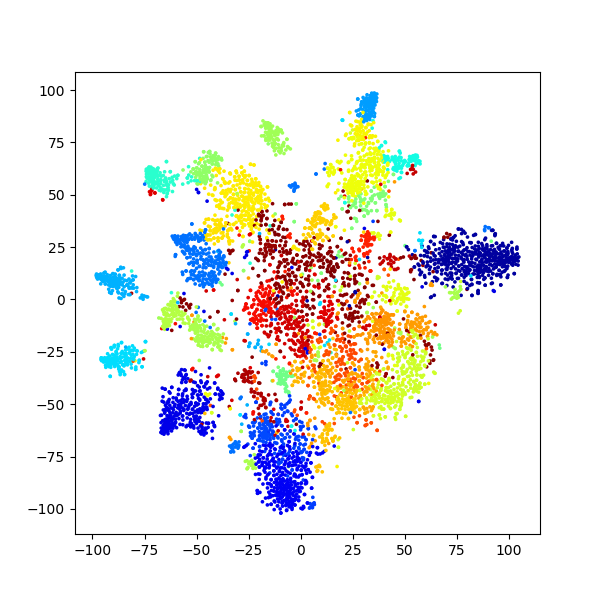

6036


In [153]:
def plot_labels(df, labels_a, standalone=True):
    if standalone == True:
        plt.figure(figsize=(6, 6))
    points = np.zeros((len(df.columns),2))
    for i, n in enumerate(df.columns):
        points[i,:] = tSNE_points[df_fish.columns.get_loc(n),:]
    print(len(points))
    plt.scatter(points[:,0], points[:,1],c=plt.cm.jet(labels_a/max(labels_a)), lw=0, alpha=1, s=7)
        #Color labels
    #plt.scatter(points[:,0], points[:,1],c=label_colors_hex, lw=0, alpha=1, s=15)
    
plot_labels(df_fish_totmol, labels_a)

In [76]:
def plot_cells_pos_labels(labels_a):
    
    coord_df_sort = sort_df(coord_df.loc[:,cellID], labels_a, row_sort=False)
    color_labels_sort =plt.cm.jet(np.sort(labels_a)/max(np.sort(labels_a)))    
    plot_cell_pos(coord_df_sort, cell_ids=None, color=color_labels_sort, s=10, standalone=False, mode='tsne')
        #Color labels: See below, part 10
    #plot_cell_pos(coord_df_sort, cell_ids=None, color=label_colors_hex, s=10, standalone=False, mode='tsne')
    
plot_cells_pos_labels(labels_a)

NameError: name 'sort_df' is not defined

<IPython.core.display.Javascript object>


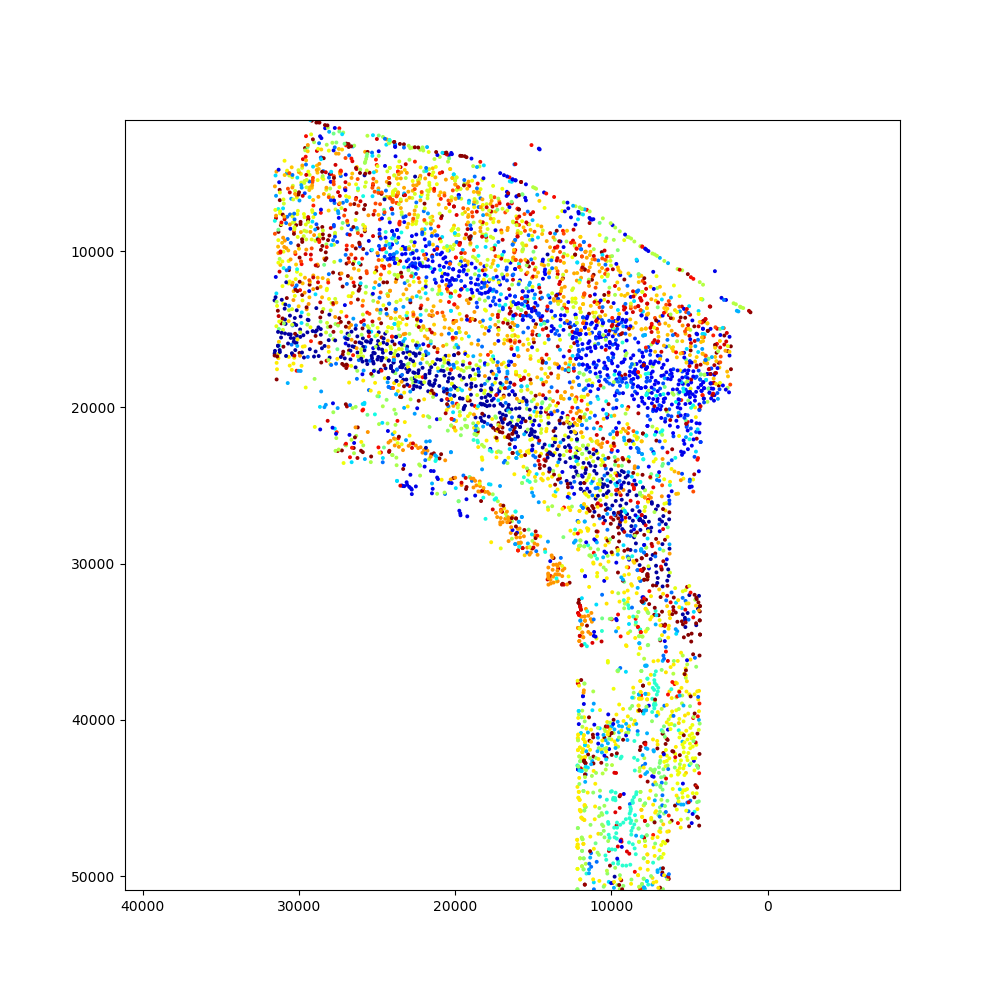

(50892.770878319228, 1610.1348403553523)

In [158]:
plt.figure(figsize=(10,10))
color_labels_sort =plt.cm.jet(labels_a/max(labels_a))
plt.scatter(coord_df.loc['X',:], coord_df.loc['Y',:], linewidths=0, c=color_labels_sort, s=8)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.gca().axis('equal')
plt.xlim([coord_df.loc['X'].max(), coord_df.loc['X'].min()])
plt.ylim([coord_df.loc['Y'].max(), coord_df.loc['Y'].min()])

<IPython.core.display.Javascript object>


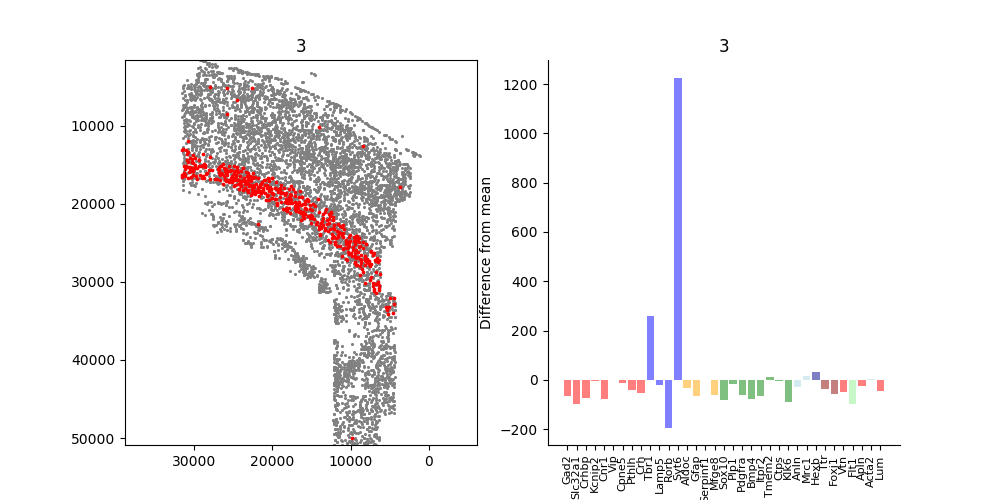

<IPython.core.display.Javascript object>


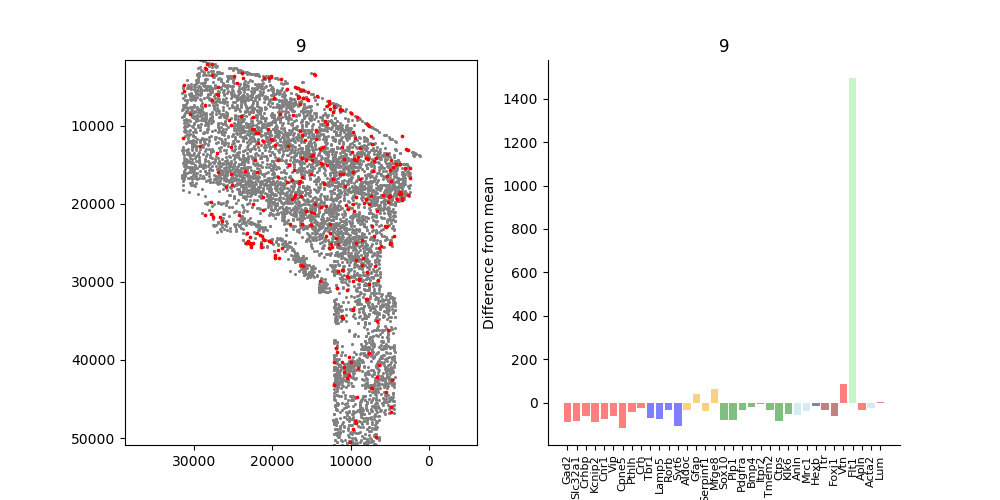

<IPython.core.display.Javascript object>


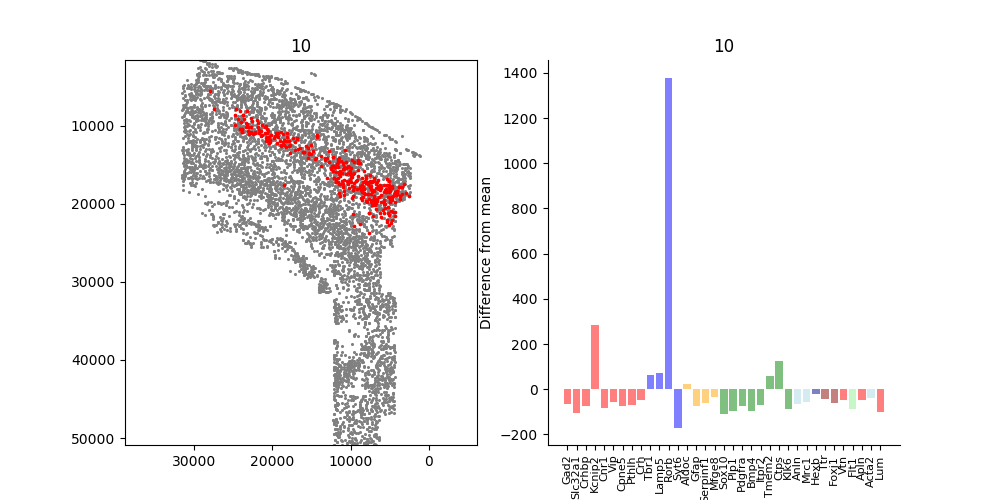

<IPython.core.display.Javascript object>


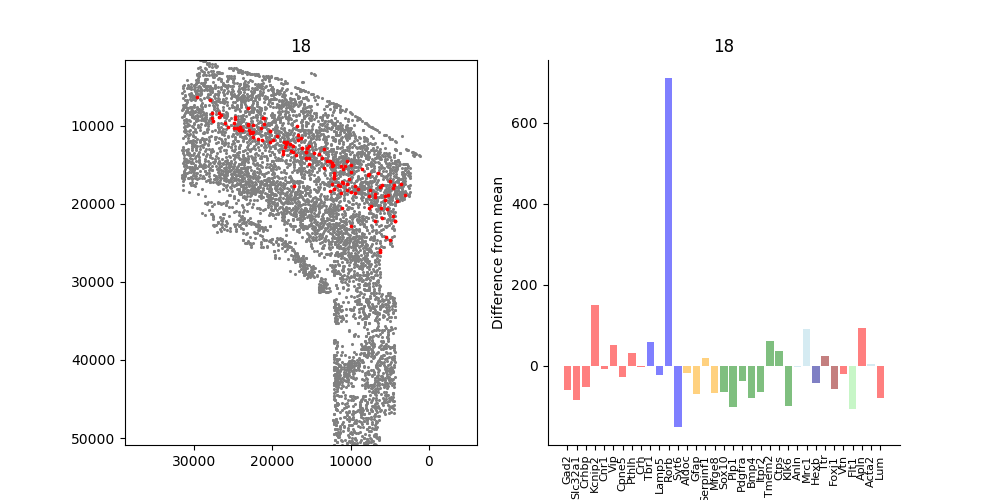

<IPython.core.display.Javascript object>


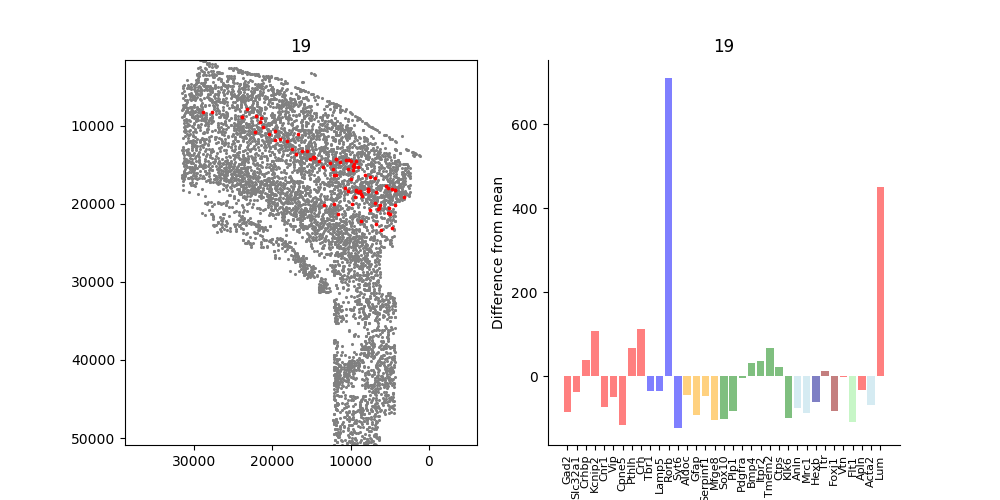

<IPython.core.display.Javascript object>


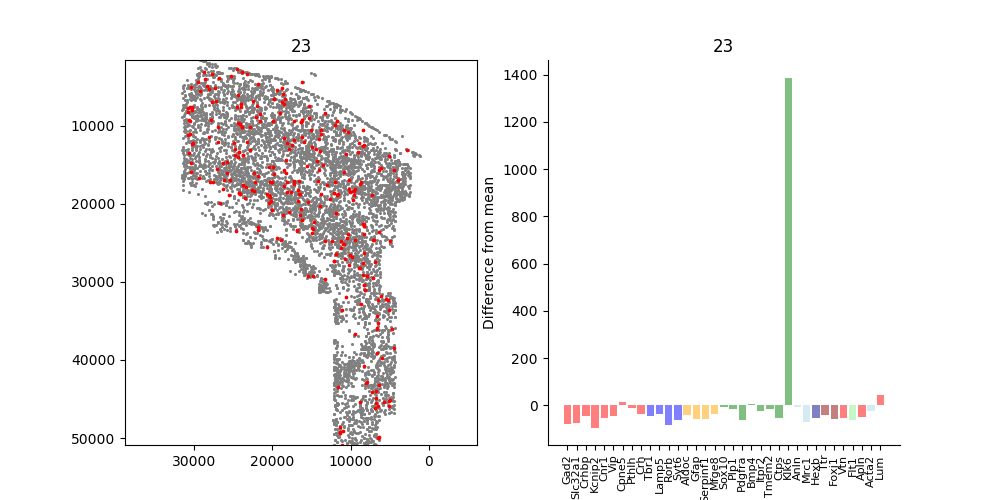

<IPython.core.display.Javascript object>


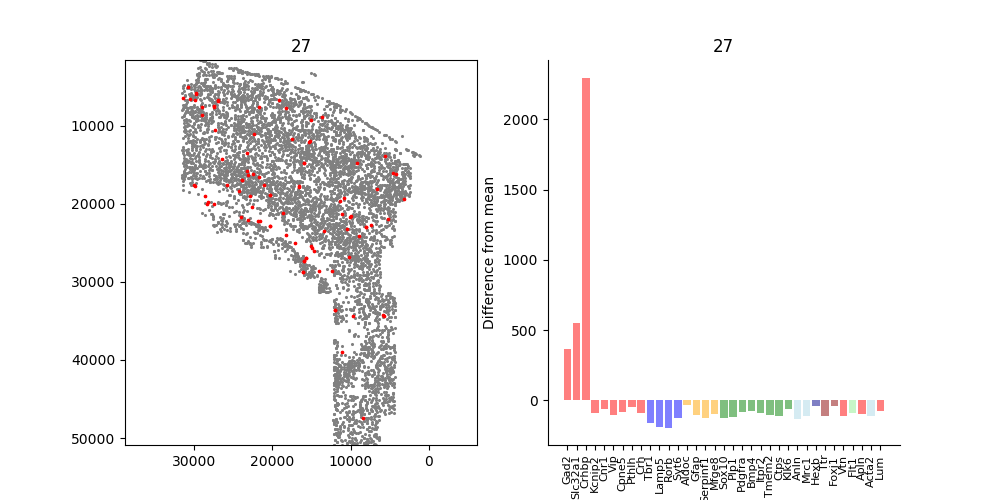

<IPython.core.display.Javascript object>


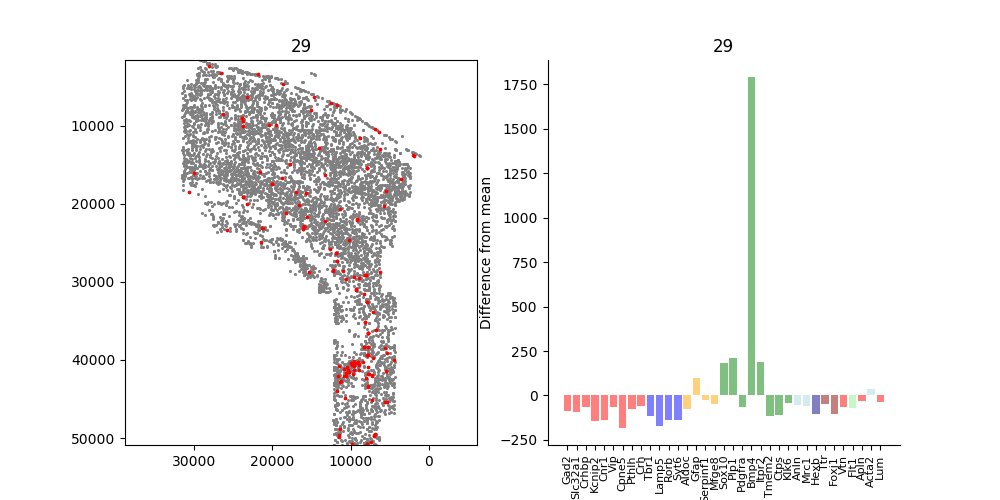

<IPython.core.display.Javascript object>


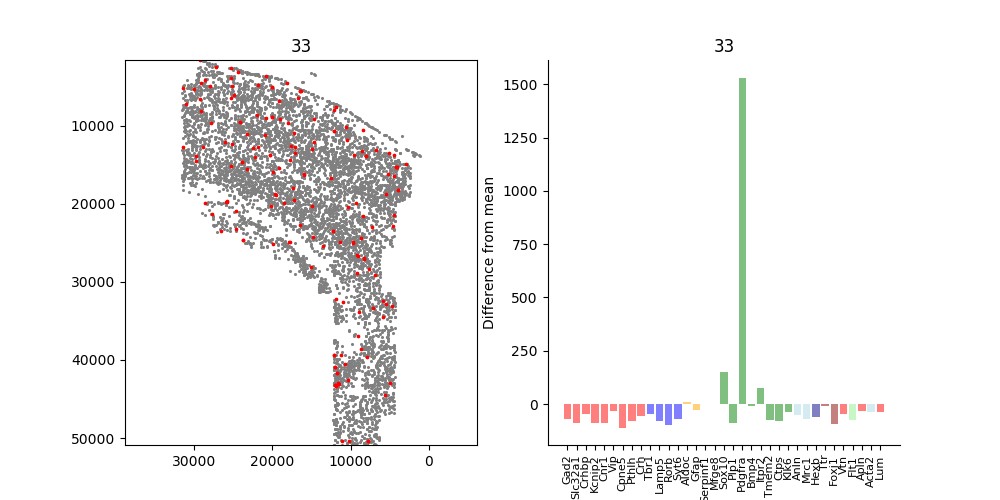

<IPython.core.display.Javascript object>


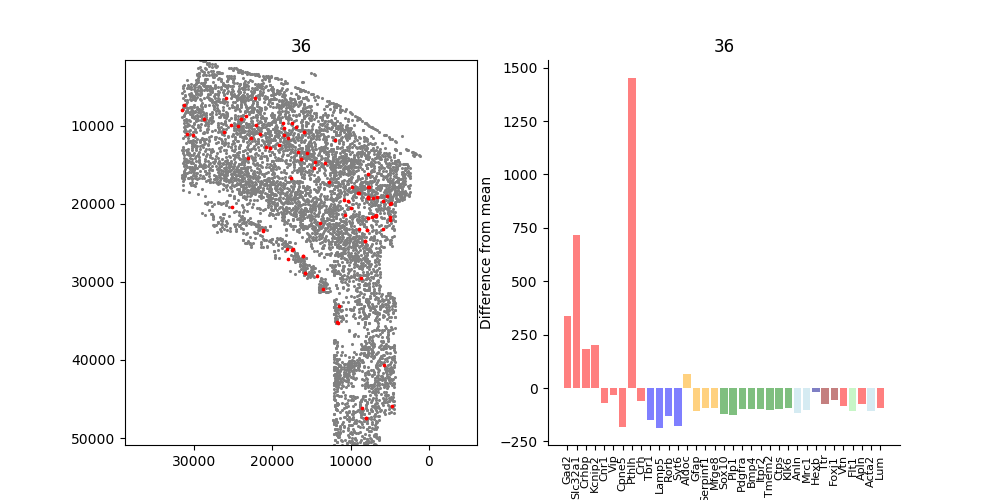

<IPython.core.display.Javascript object>


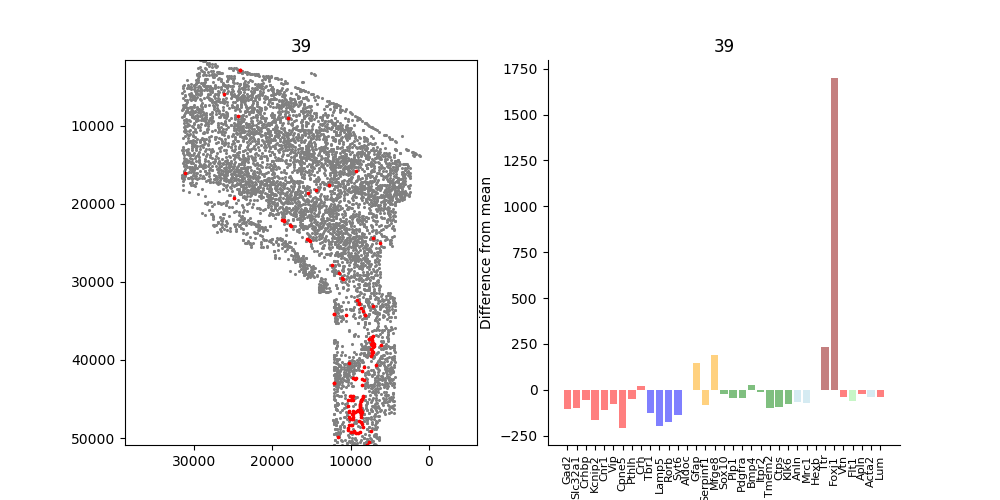

<IPython.core.display.Javascript object>


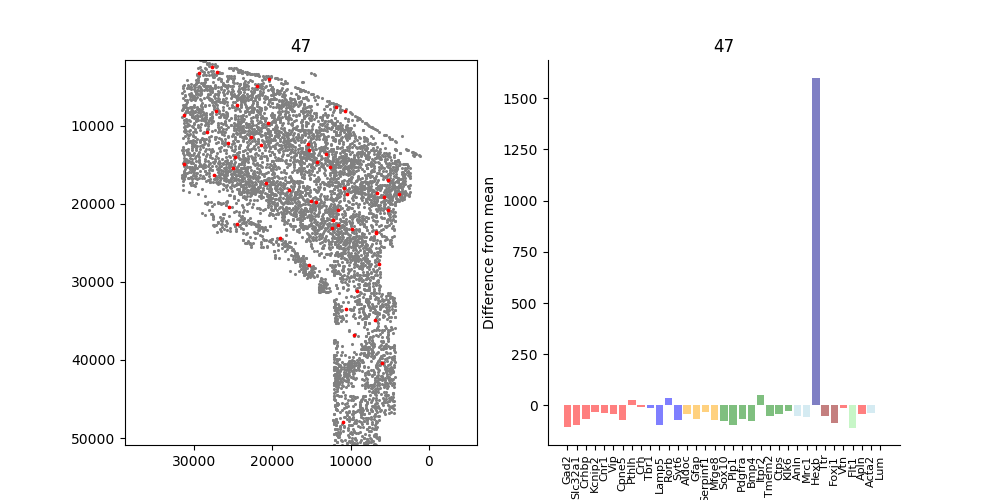

<IPython.core.display.Javascript object>


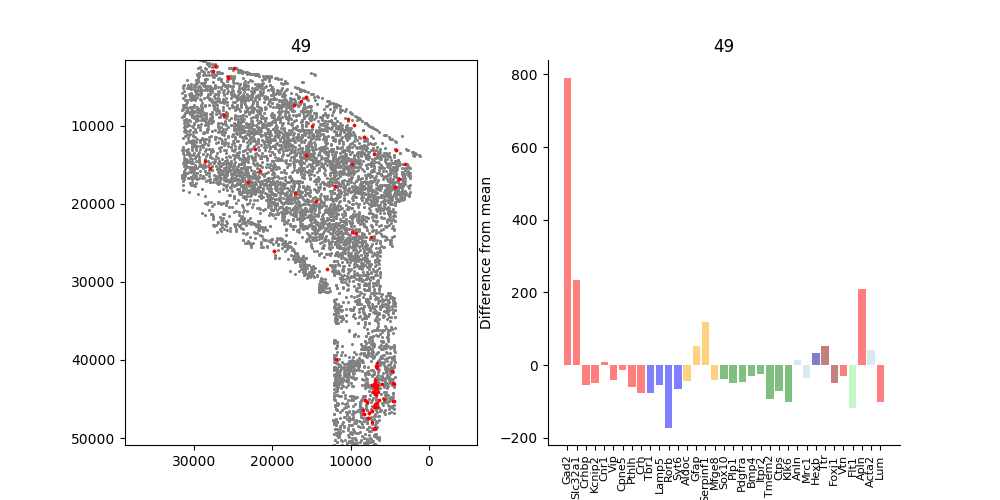

<IPython.core.display.Javascript object>


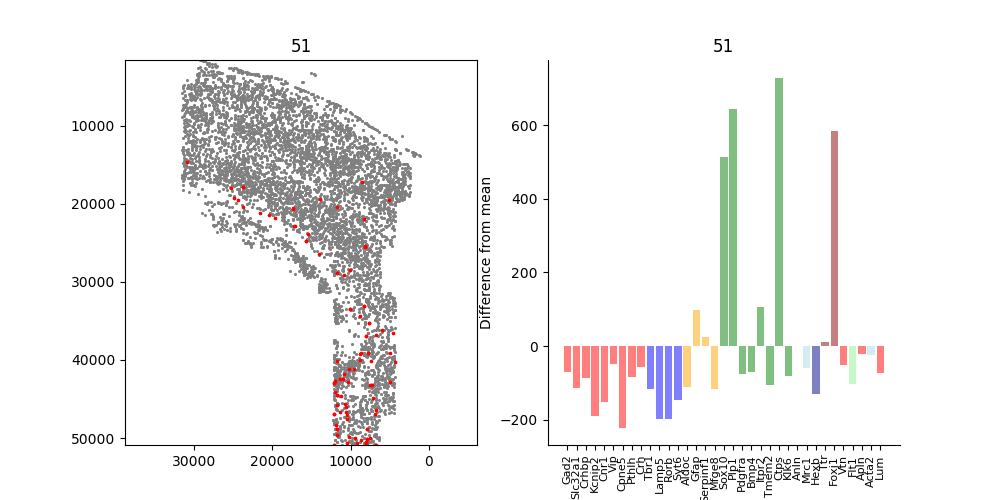

<IPython.core.display.Javascript object>


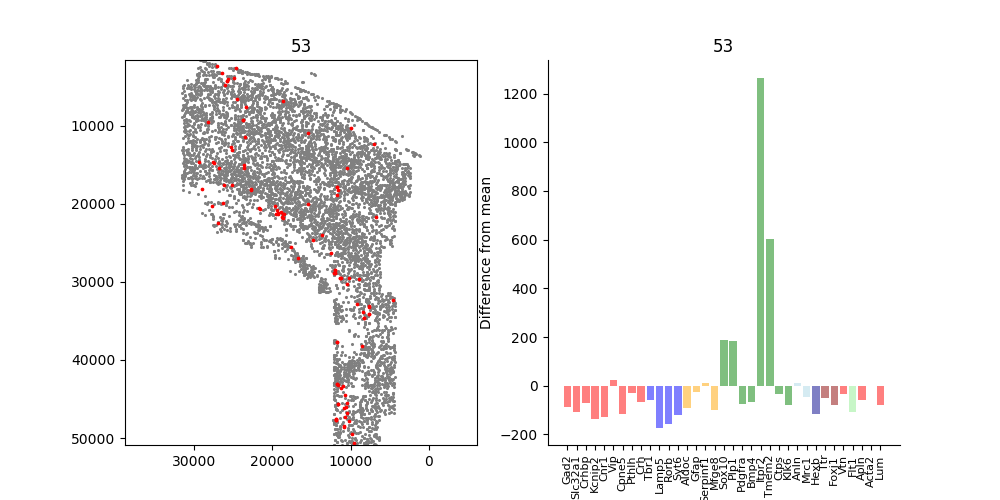

<IPython.core.display.Javascript object>


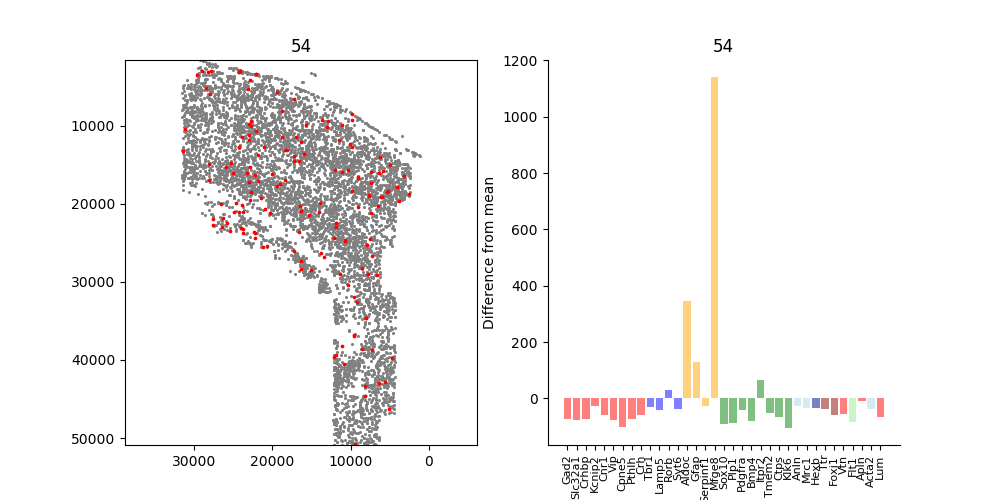

<IPython.core.display.Javascript object>


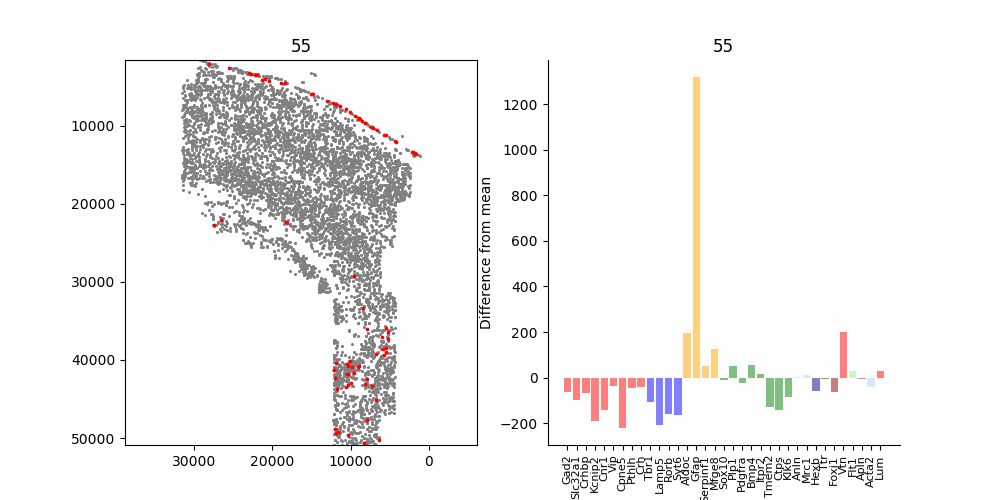

<IPython.core.display.Javascript object>


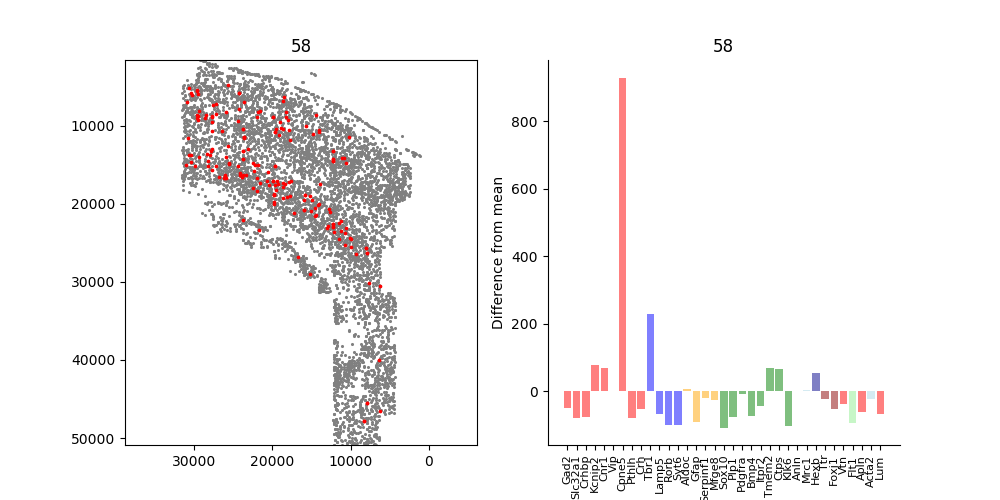

<IPython.core.display.Javascript object>


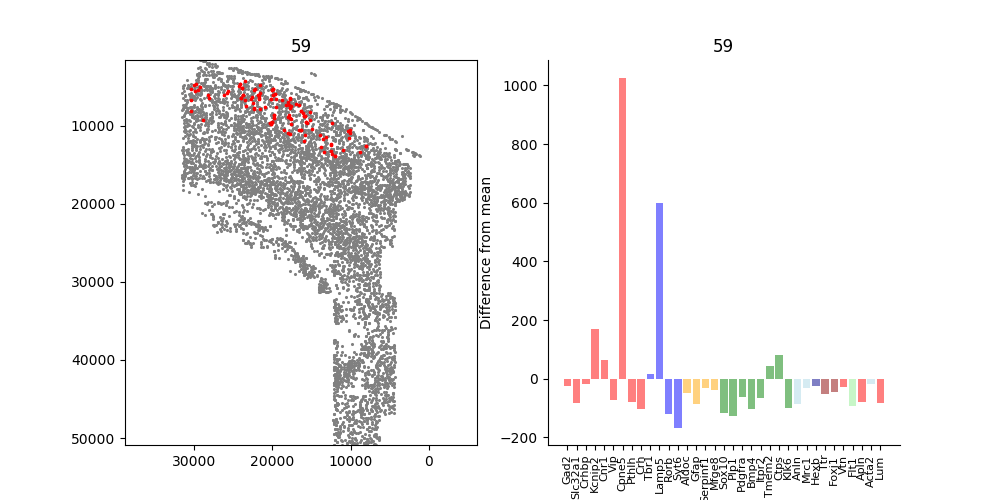

<IPython.core.display.Javascript object>


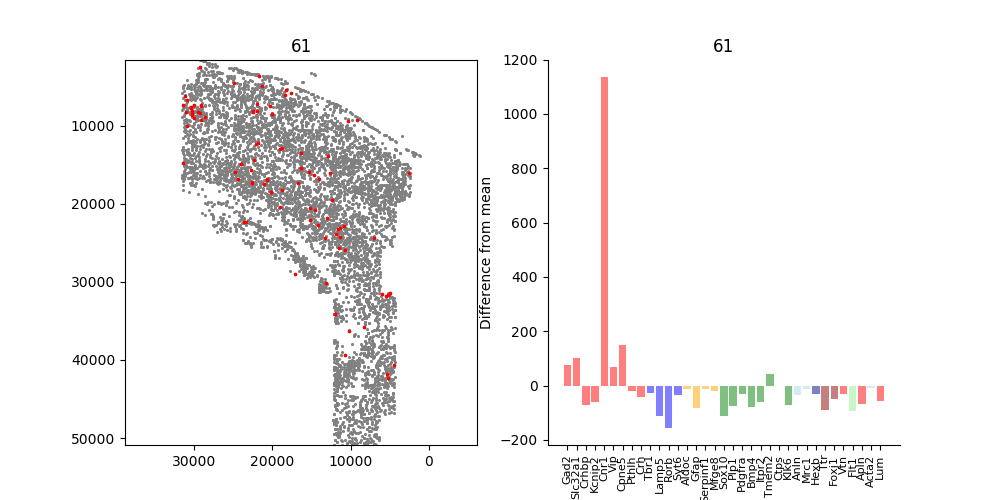

<IPython.core.display.Javascript object>


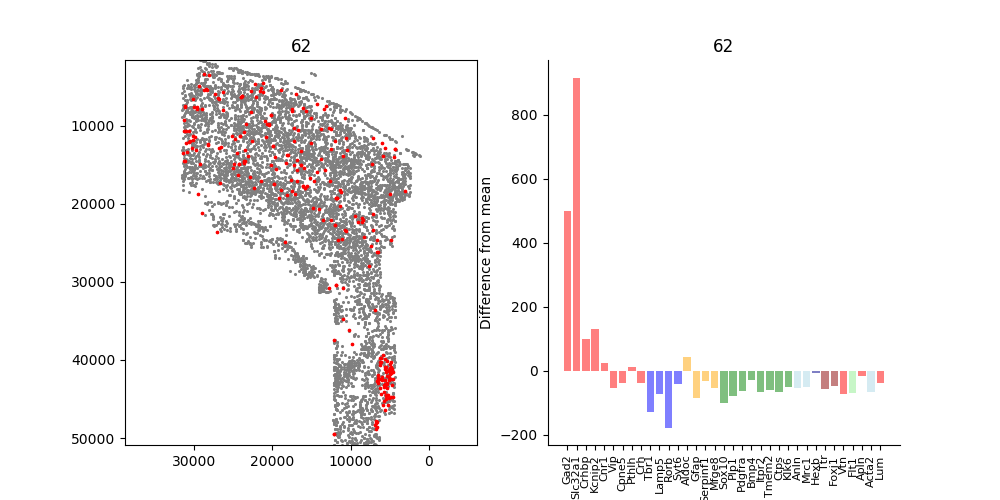

<IPython.core.display.Javascript object>


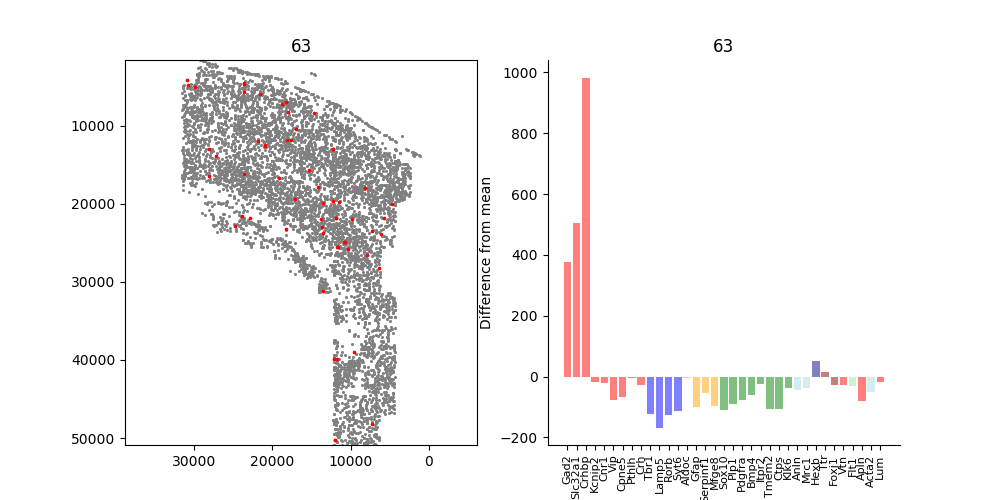

<IPython.core.display.Javascript object>


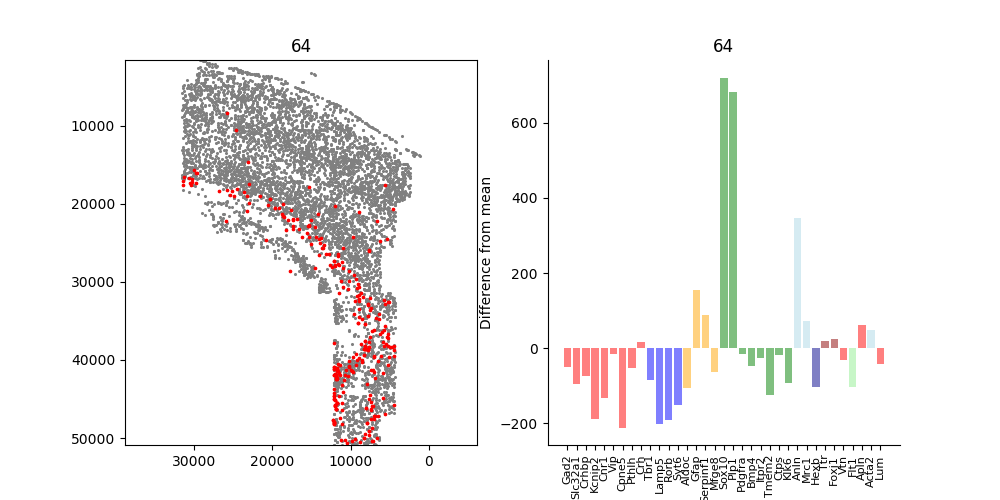

<IPython.core.display.Javascript object>


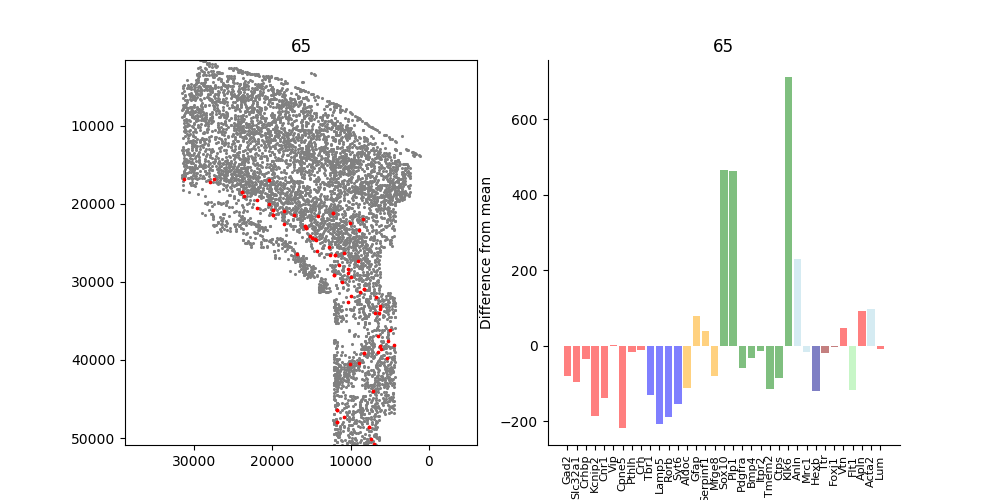

<IPython.core.display.Javascript object>


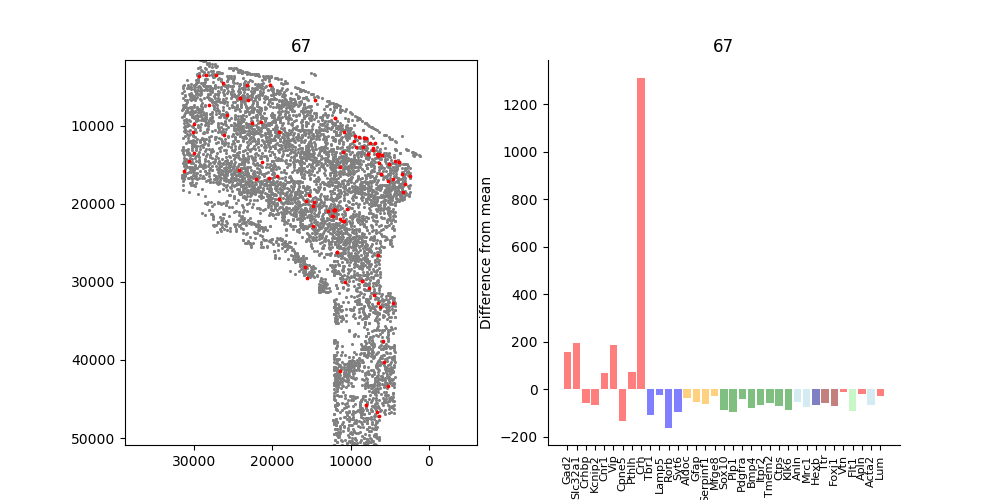

<IPython.core.display.Javascript object>


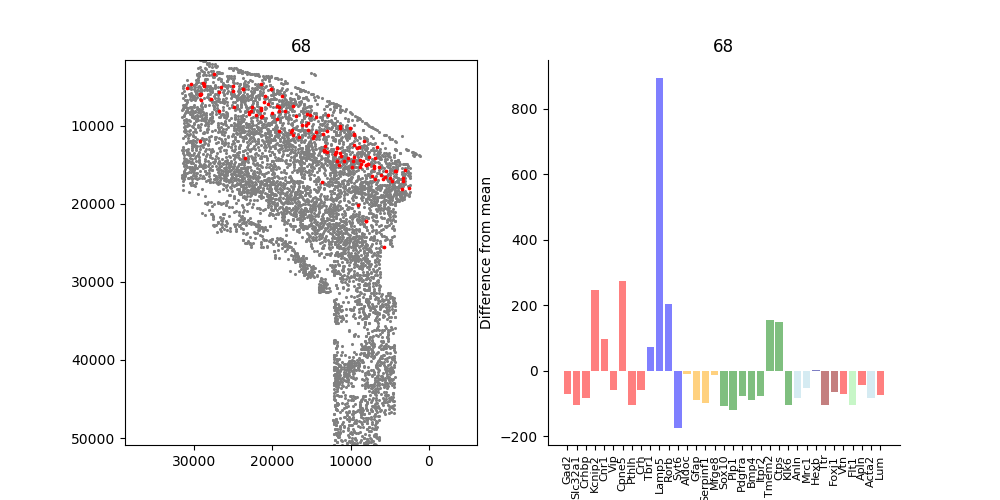

<IPython.core.display.Javascript object>


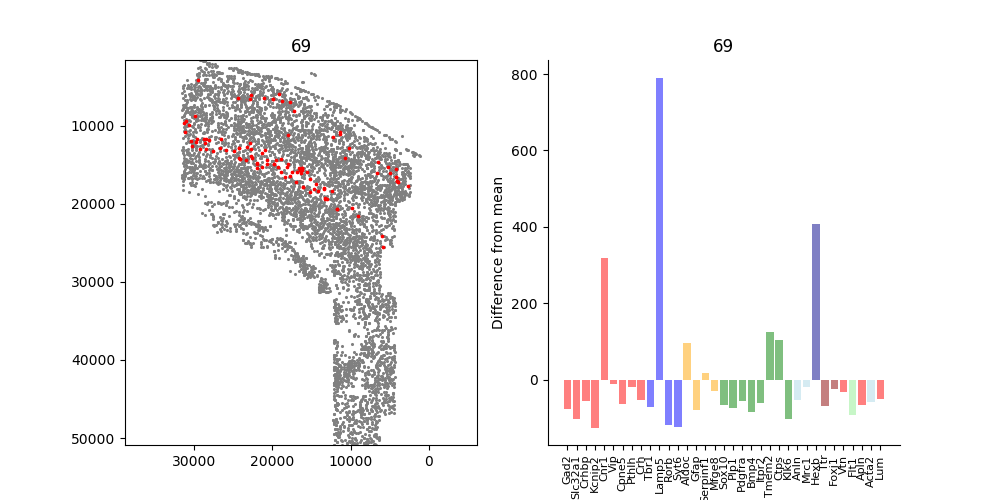

<IPython.core.display.Javascript object>


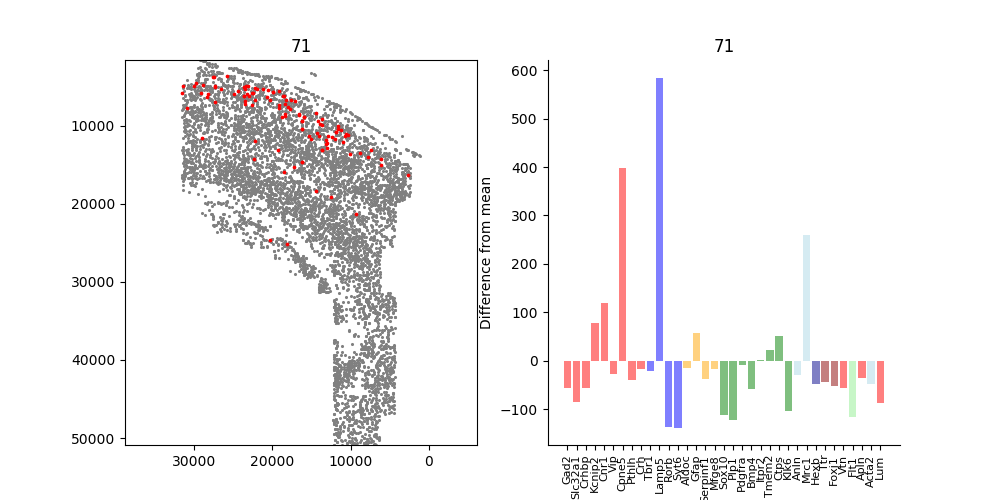

<IPython.core.display.Javascript object>


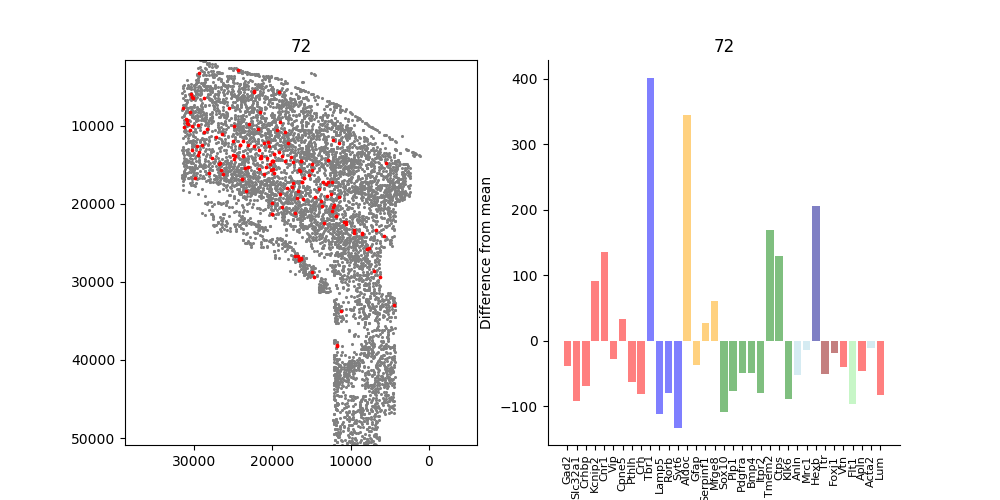

<IPython.core.display.Javascript object>


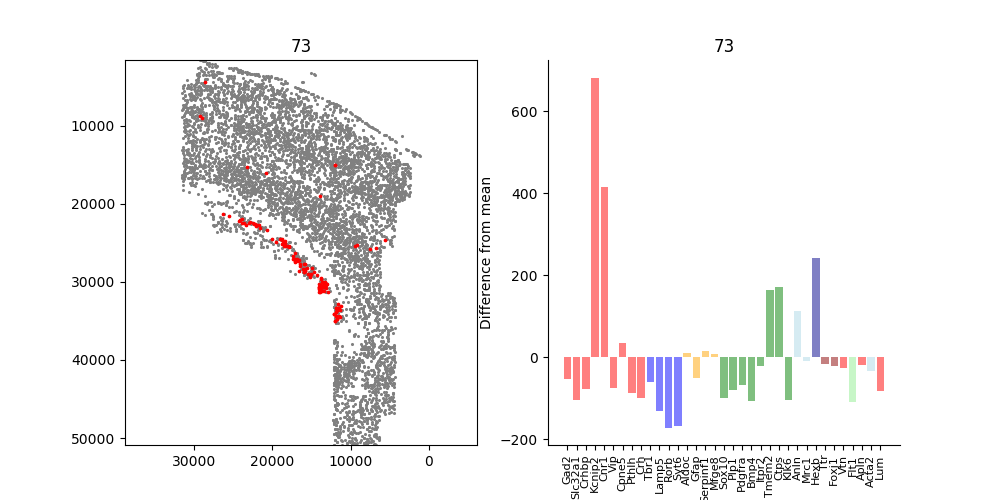

<IPython.core.display.Javascript object>


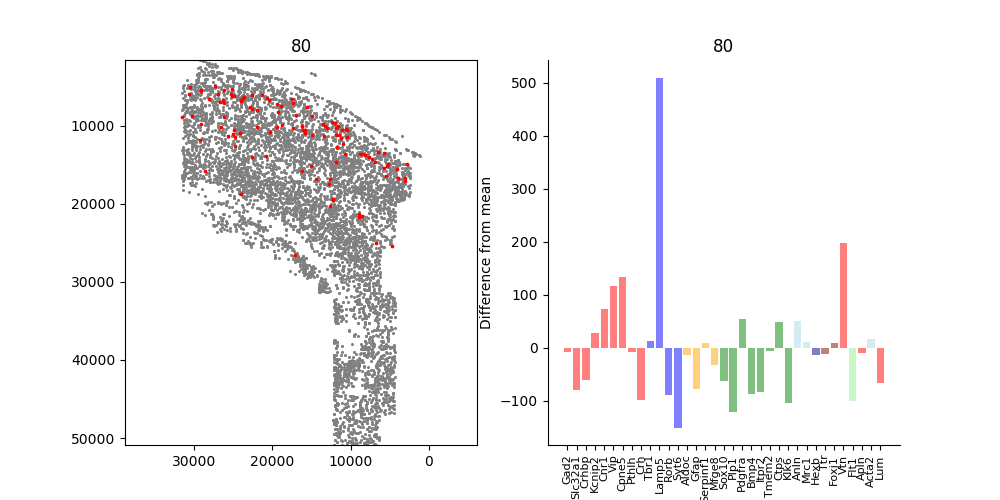

<IPython.core.display.Javascript object>


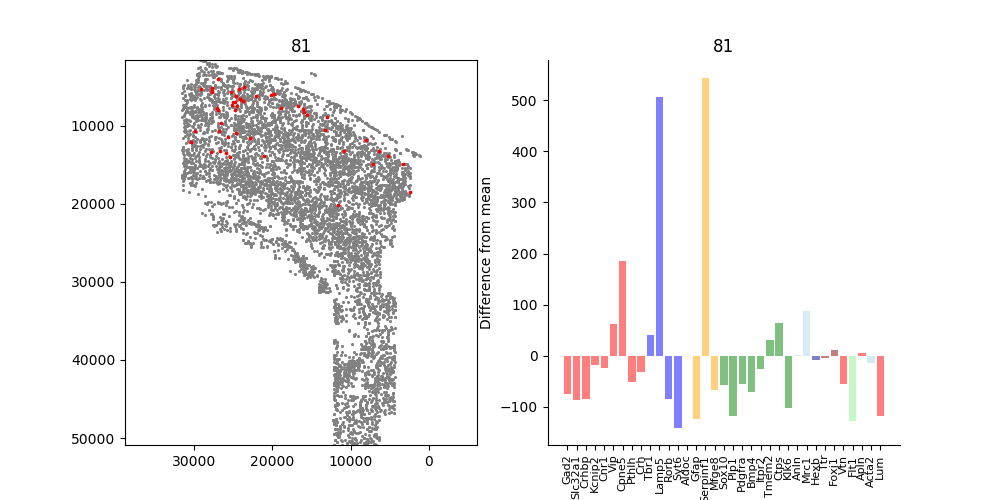

<IPython.core.display.Javascript object>


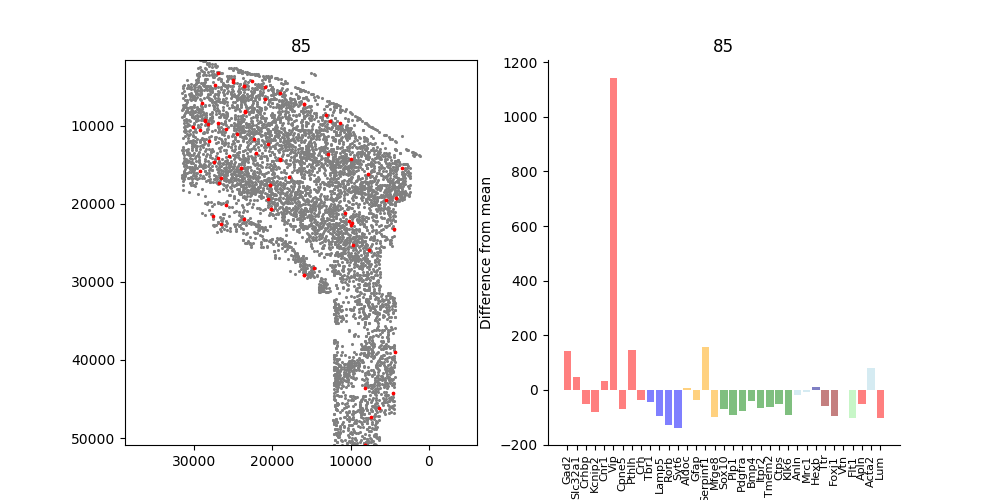

<IPython.core.display.Javascript object>


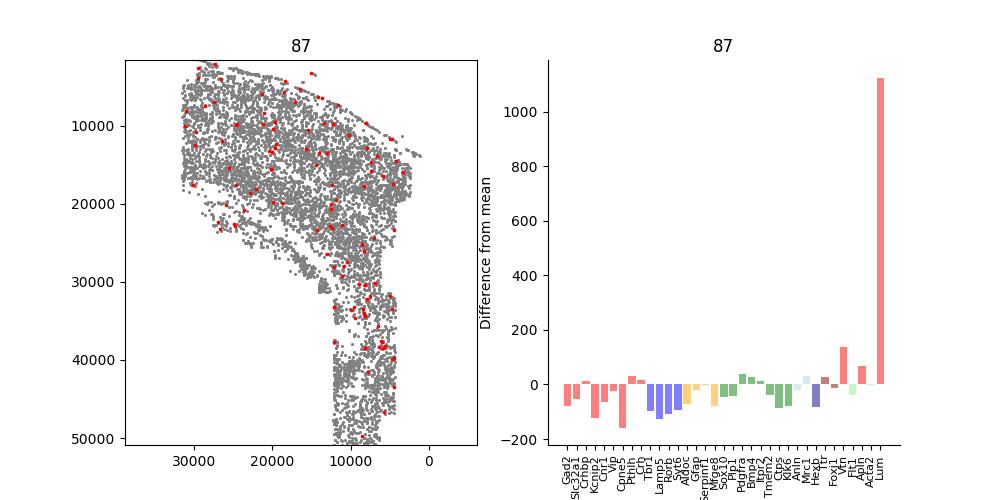

<IPython.core.display.Javascript object>


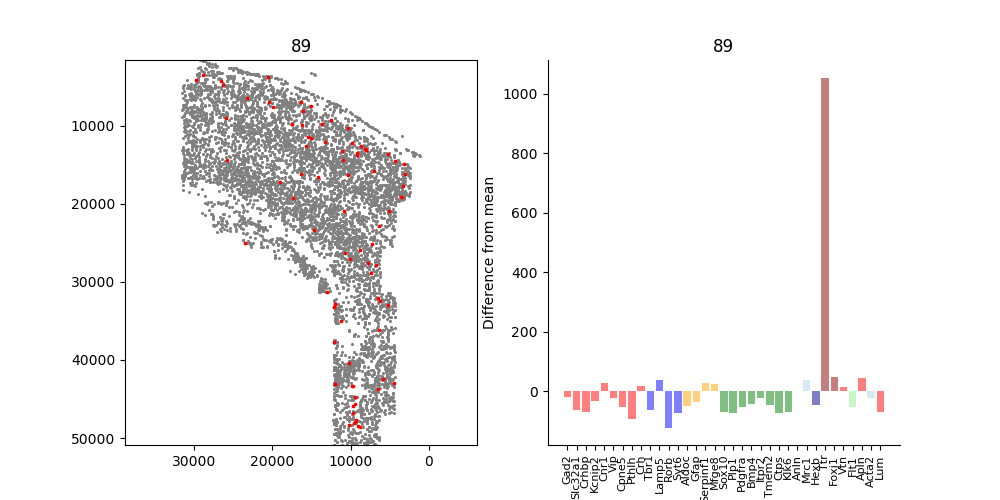

<IPython.core.display.Javascript object>


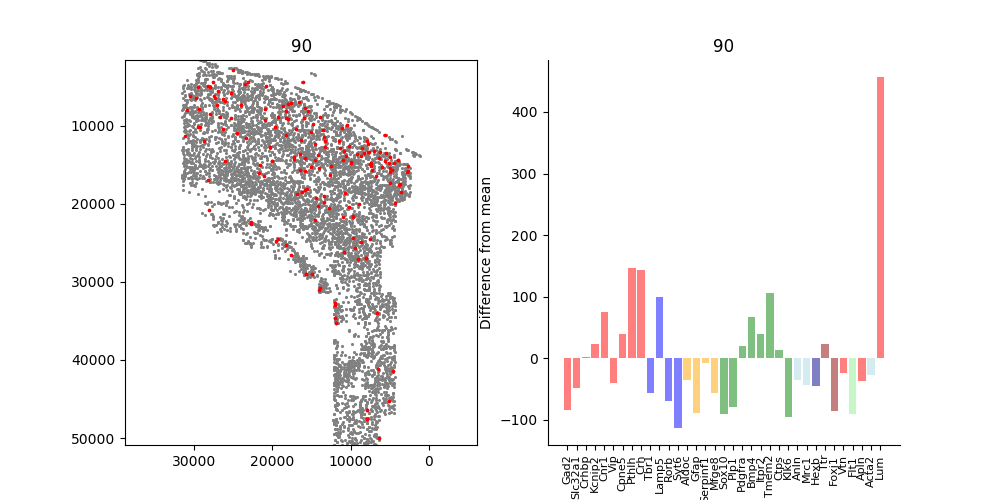

<IPython.core.display.Javascript object>


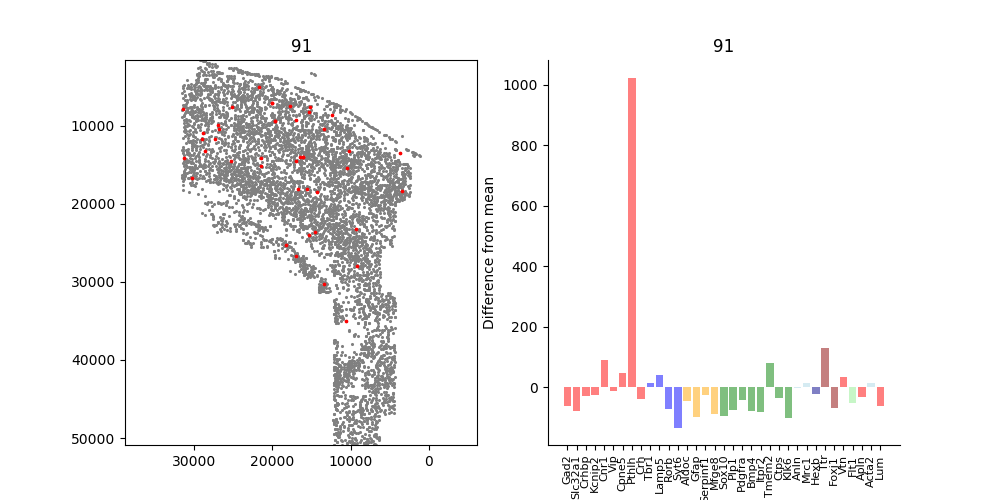

<IPython.core.display.Javascript object>


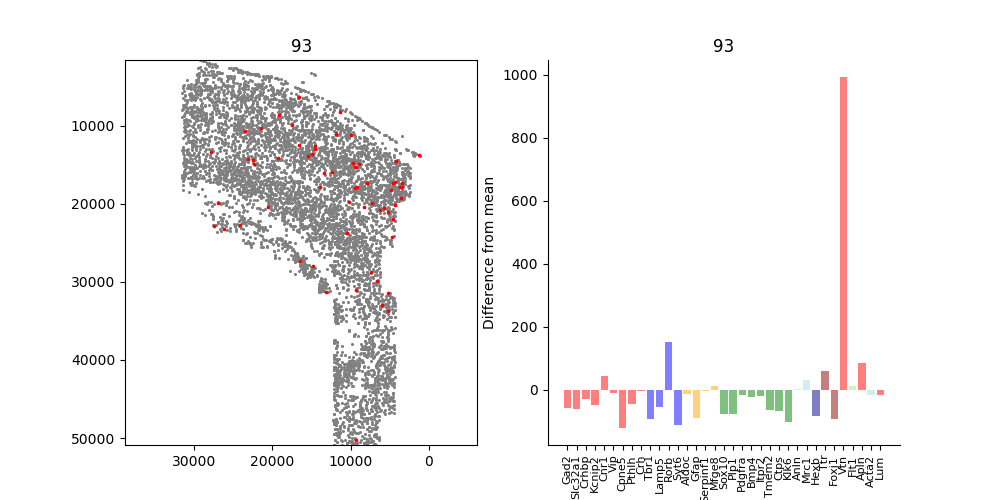

<IPython.core.display.Javascript object>


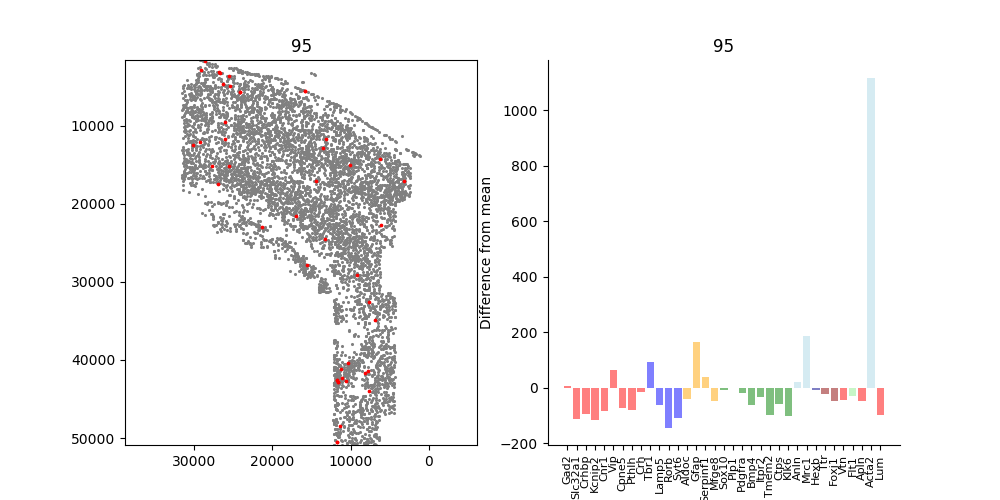

<IPython.core.display.Javascript object>


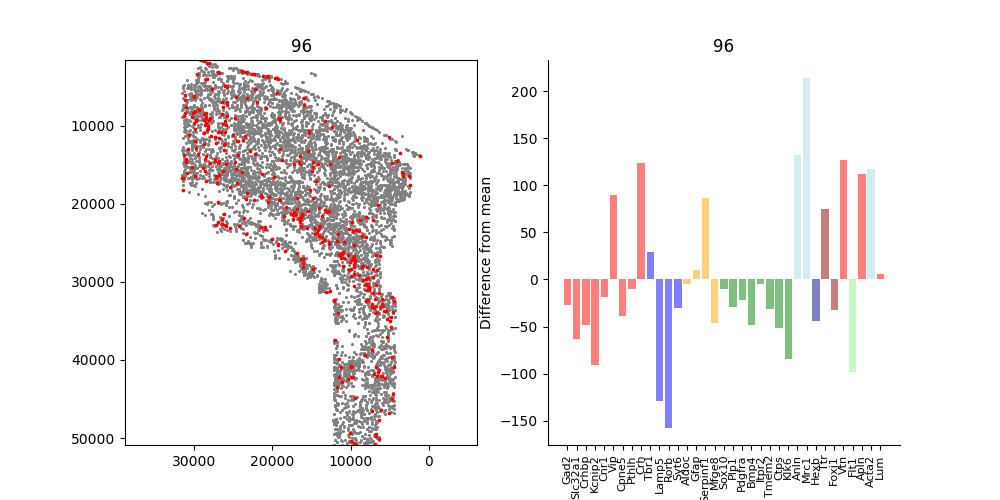

<IPython.core.display.Javascript object>


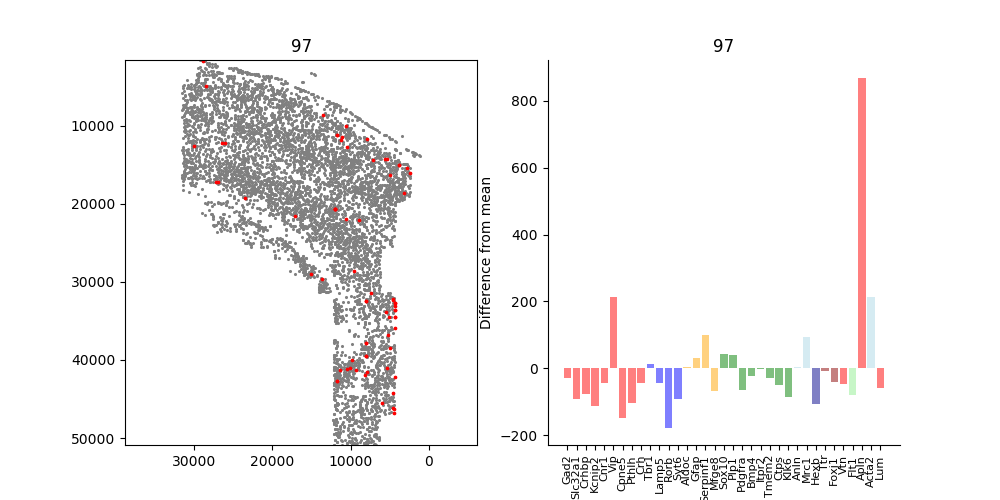

In [159]:

for i in np.unique(labels): 
    fig, (ax1, ax2) = plt.subplots(1,2, sharey=False, figsize=(10,5))
    ax1.scatter(coord_df.loc['X',:], coord_df.loc['Y',:], linewidths=0, c='grey', s=5)
    filt = labels_a == i
    ax1.scatter(coord_df.loc['X',filt], coord_df.loc['Y',filt], linewidths=0, c='red', s=7)
    ax1.invert_xaxis()
    ax1.invert_yaxis()
    ax1.axis('equal')
    ax1.set_xlim([coord_df.loc['X'].max(), coord_df.loc['X'].min()])
    ax1.set_ylim([coord_df.loc['Y'].max(), coord_df.loc['Y'].min()])
    ax1.set_title(i)
    
    data = df_fish_totmol.loc[:,filt]
    gene_colors = ['red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red','blue', 'blue', 'blue', 'blue','orange', 'orange', 'orange', 'orange',
        'green', 'green', 'green', 'green', 'green',  'green', 'green', 'green',
        'lightblue', 'lightblue', 'darkblue', 'darkred','darkred','red','lightgreen','red','lightblue']
    left_pos = range(data.shape[0])

    ax2.bar(left_pos, data.mean(axis=1) - df_fish_totmol.mean(axis=1), color=gene_colors, alpha=0.5)
    x_lab = [i.split('_')[1] for i in list(df_fish_totmol.index)]
    ax2.set_xticks(left_pos)
    ax2.set_xticklabels(x_lab, rotation='vertical', fontsize=8)
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.yaxis.set_ticks_position('left')
    ax2.xaxis.set_ticks_position('bottom')
    ax2.set_title(i)
    ax2.set_ylabel('Difference from mean')
   

In [68]:
labels_a == 3

6036